In [1]:
import cupy as cp
import matplotlib.pyplot as plt
from functions import R,RT,mshow_complex,mshow
from phantom import *

# Generate phantom (Doga)

(64, 64, 64, 3)


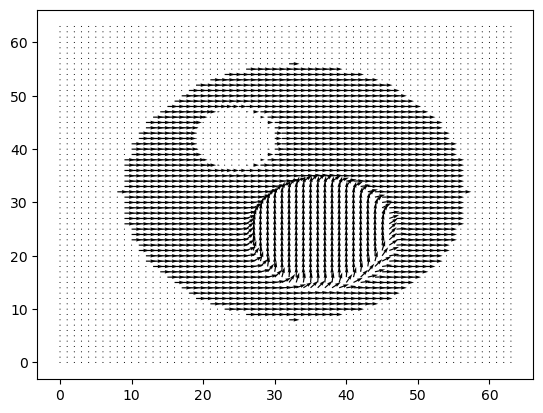

In [2]:
#####################################################
# Create a test 3D vector field 
#####################################################

scale = 1
shape = (scale*64, scale*64, scale*64)
centers = np.array([
    (scale*32, scale*32, scale*32),  # Center of first circle
    (scale*24, scale*36, scale*32),  # Center of second circle
    (scale*42, scale*24, scale*32),  # Center of third circle
])
radii = np.array([
    scale*24,  # Radius of first circle
    scale*10,  # Radius of second circle
    scale*6,   # Radius of third circle
]) 
domains = np.array([
    (0, np.pi/2),        # X direction
    (np.pi/2, np.pi/2),  # Y direction  
    (0, 0)               # Z direction
])

# Create the phantom
field, mask = create_vector_field_phantom_3d(
    shape, centers, radii, domain_angles=domains, transition_width=scale*1.0)

print (field.shape)

plt.quiver(field[:, :, 32, 0], field[:, :, 32, 1])
plt.show()  


In [3]:
w = cp.array(field)

## Tomography parameters

In [4]:
theta = cp.linspace(0,cp.pi,60,endpoint=True).astype('float32')
rotation_axis = w.shape[1]/2
w_shape = w.shape
data_shape = [w.shape[0],len(theta),w.shape[2]]


## Find mask

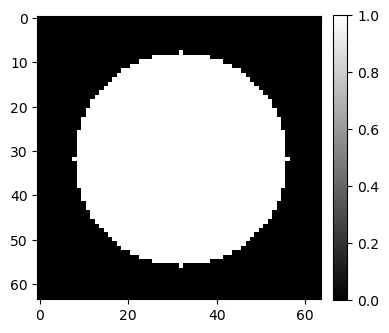

In [5]:
mask = cp.array(mask)[...,cp.newaxis] # already given 
mshow(mask[w_shape[0]//2,...,0],True)
# w_abs = np.linalg.norm(w,axis=-1)
# mshow(w_abs[w_shape[0]//2],True)

# mask = (w_abs>0).astype('float32')[...,cp.newaxis]


# Make operators

### $P_\theta(w) = \mathcal{R}_\theta (w_x) \cos\theta + \mathcal{R}_\theta (w_y) \sin\theta$

In [6]:
def P(w):
    Rw = cp.zeros(data_shape,dtype='float32')
    t = [-cp.cos(theta)[:,cp.newaxis],
        -cp.sin(theta)[:,cp.newaxis],
        0]###???    
    for k in range(3):
        Rw += t[k]*R(w[...,k].astype('complex64'),theta,rotation_axis).real
    return Rw
   
def Padj(Rw):
    t = [-cp.cos(theta)[:,cp.newaxis],
        -cp.sin(theta)[:,cp.newaxis],
        0]###???
    w = cp.zeros(w_shape,dtype='float32')
    for k in range(3):
        w[...,k] = RT((Rw*t[k]).astype('complex64'),theta,rotation_axis).real
    return w    

# Adjoint test

In [7]:
a = cp.random.random(w_shape,dtype='float32')
b = cp.random.random(data_shape,dtype='float32')
bb = P(a)
aa = Padj(b)
print(cp.sum(aa*a))
print(cp.sum(bb*b))

-39725.094
-39725.1


# Data simulation

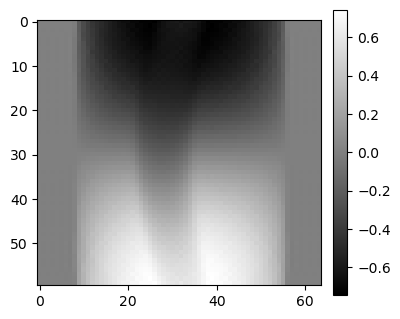

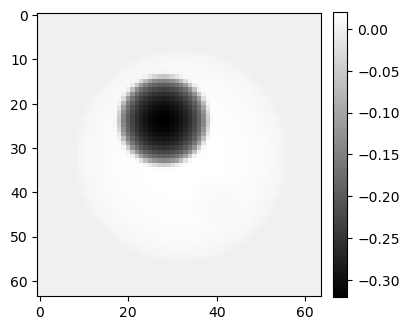

In [8]:
rotation_axis = data_shape[-1]//2
data = P(w)
mshow(data[data.shape[0]//2])
mshow(data[:,data.shape[1]//2])

### $F_1(w) = \sum_\theta\|P_\theta(M(w))-d_\theta\|_2^2$

In [9]:

def F1(w):
    return cp.linalg.norm(P(mask*w)-data)**2

def dF1(w,y):
    return 2*cp.sum((P(mask*w)-data)*P(mask*y))

def d2F1(w,y,z):
    return 2*cp.sum(P(mask*y)*P(mask*y))

def dF1adj(w,y):
    return 2*mask*Padj(P(mask*w)-data)*y

### Approximation test

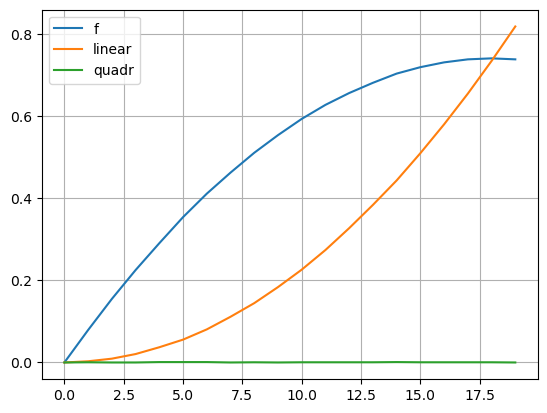

In [10]:
w = cp.random.random(w_shape).astype('float32')
dw0 = cp.random.random(w_shape).astype('float32')/10

l = cp.linspace(0,0.1,20).astype('float32')
err1 = np.zeros(20)
err2 = np.zeros(20)
err3 = np.zeros(20)
for k in range(20):
    dw = l[k]*dw0
    a = F1(w+dw)
    err1[k] = cp.linalg.norm(F1(w)-a)
    err2[k] = cp.linalg.norm(F1(w)+dF1(w,dw)-a)    
    err3[k] = cp.linalg.norm(F1(w)+dF1(w,dw)+0.5*d2F1(w,dw,dw)-a)
plt.plot(err1,label='f')
plt.plot(err2,label='linear')
plt.plot(err3,label='quadr')
plt.legend()
plt.grid()
# plt.yscale('log')
plt.show()
# ss

### Adjoint test

In [11]:
w = cp.random.random(w_shape).astype('float32')
dw = cp.random.random(w_shape).astype('float32')/10

a = dF1(w,dw)
b = dF1adj(w,a)

print(cp.sum(a*a))
print(cp.sum(dw*b))

142.62347
142.62386


### $ F_{21}(w,v) = \|M(w)\cdot v\|_2^2$

In [12]:
def F21(x):
    w,v = x
    w*=mask
    wv = cp.sum(w*v,axis=-1)
    return cp.linalg.norm(wv)**2

def dF21(x,y):
    w,v = x
    dw,dv = y
    w*=mask
    dw*=mask
    t1 = cp.sum(w*v,axis=-1)
    t2 = cp.sum(dw*v,axis=-1)+cp.sum(w*dv,axis=-1)
    return 2*cp.sum(t1*t2)

def d2F21(x,y,z):
    w,v = x
    dw1,dv1 = y
    dw2,dv2 = z
    w*=mask
    dw1*=mask
    dw2*=mask
    
    wv = cp.sum(w*v,axis=-1)
    dw1v2 = cp.sum(dw1*dv2,axis=-1)
    dw2v1 = cp.sum(dw2*dv1,axis=-1)
    t1 = cp.sum(wv*(dw1v2+dw2v1))

    dw1v = cp.sum(dw1*v,axis=-1)
    wdv1 = cp.sum(w*dv1,axis=-1)
    dw2v = cp.sum(dw2*v,axis=-1)
    wdv2 = cp.sum(w*dv2,axis=-1)
    t2 = cp.sum((dw1v+wdv1)*(dw2v+wdv2))
    return 2*(t1+t2)

def dF21adj(x,y):
    w,v = x
    w*=mask
    wv = cp.sum(w*v,axis=-1)*y
    dw = 2*wv[...,cp.newaxis]*v
    dv = 2*cp.sum(wv[...,cp.newaxis]*w,axis=(0,1,2))
    dw*=mask
    return [dw,dv]



### Approximation test

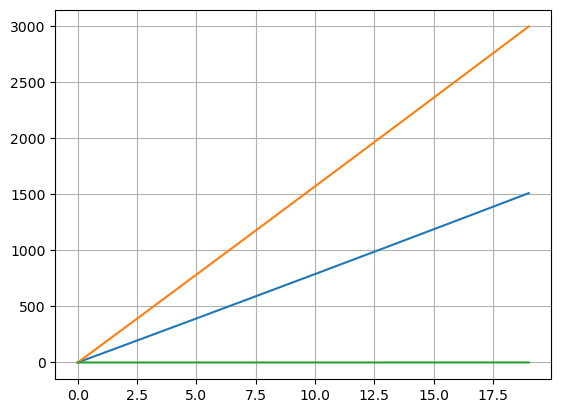

In [13]:
w = cp.random.random(w_shape).astype('float32')
dw0 = cp.random.random(w_shape).astype('float32')/10
v = cp.random.random(3).astype('float32')
dv0 = cp.random.random(3).astype('float32')/10

l = cp.linspace(0,0.1,20).astype('float32')
err1 = np.zeros(20)
err2 = np.zeros(20)
err3 = np.zeros(20)
for k in range(20):
    dw = l[k]*dw0
    dv = l[k]*dv0
    a = F21([w+dw,v+dv])
    #print(cp.linalg.norm(dF21([w,v],[dw,0*dv])),cp.linalg.norm(dF21([w,v],[0*dw,dv])))
    err1[k] = cp.linalg.norm(F21([w,v])-a)
    err2[k] = cp.linalg.norm(F21([w,v])-dF21([w,v],[dw,dv])-a)    
    err3[k] = cp.linalg.norm(F21([w,v])+dF21([w,v],[dw,dv])+0.5*d2F21([w,v],[dw,dv],[dw,dv])-a)
plt.plot(err1,label='f')
plt.plot(err2,label='linear')
plt.plot(err3,label='quadr')
plt.grid()
# plt.yscale('log')
plt.show()

### ADjoint test for the gradient

In [14]:

w = cp.random.random(w_shape).astype('float32')
v = cp.random.random(3).astype('float32')
dw = cp.random.random(w_shape).astype('float32')/4
dv = cp.random.random(3).astype('float32')/4

a = dF21([w,v],[dw,dv])
b = dF21adj([w,v],a)

print(cp.sum(a*a))
print(cp.sum(dw*b[0])+cp.sum(dv*b[1]))

217471100.0
217471100.0


### $F_{22}(\phi) = [\cos(\phi_1) \sin(\phi_2), \sin(\phi_1) \sin(\phi_2), \cos(\phi_2)] $

In [15]:
def F22(x):
    w,phi = x    
    t1 = cp.cos(phi[0])*cp.sin(phi[1])
    t2 = cp.sin(phi[0])*cp.sin(phi[1])
    t3 = cp.cos(phi[1])    
    return [w,cp.array([t1,t2,t3])]

def dF22(x,y):
    w,phi = x
    dw,dphi = y
    mat = cp.array(
        [[-cp.sin(phi[0])*cp.sin(phi[1]),cp.cos(phi[0])*cp.sin(phi[1]), cp.array(0)],
         [cp.cos(phi[0])*cp.cos(phi[1]),cp.sin(phi[0])*cp.cos(phi[1]),-cp.sin(phi[1])]])
    t1 = mat[0,0]*dphi[0]+mat[1,0]*dphi[1]
    t2 = mat[0,1]*dphi[0]+mat[1,1]*dphi[1]
    t3 = mat[0,2]*dphi[0]+mat[1,2]*dphi[1]
    return [dw,cp.array([t1,t2,t3])]

def d2F22(x,y,z):
    w,phi = x
    dw1,dphi1 = y
    dw2,dphi2 = z
    
    d22 = cp.array([-cp.cos(phi[0])*cp.sin(phi[1]),-cp.sin(phi[0])*cp.sin(phi[1]),-cp.cos(phi[1])])
    d11 = cp.array([-cp.cos(phi[0])*cp.sin(phi[1]),-cp.sin(phi[0])*cp.sin(phi[1]),cp.array(0)])
    d22 = cp.array([-cp.cos(phi[0])*cp.sin(phi[1]),-cp.sin(phi[0])*cp.sin(phi[1]),-cp.cos(phi[1])])
    d12 = cp.array([-cp.sin(phi[0])*cp.cos(phi[1]),-cp.cos(phi[0])*cp.cos(phi[1]),cp.array(0)])
    res =  (dphi1[0]*dphi2[0]*d11+
            dphi1[1]*dphi2[1]*d22+
            (dphi1[0]*dphi2[1]+dphi1[1]*dphi2[0])*d12)
    return [0,res]
  
def dF22adj(x,y):
    w,phi = x
    dw,dv = y
    
    mat = cp.array(
        [[-cp.sin(phi[0])*cp.sin(phi[1]),cp.cos(phi[0])*cp.sin(phi[1]), cp.array(0)],
         [cp.cos(phi[0])*cp.cos(phi[1]),cp.sin(phi[0])*cp.cos(phi[1]),-cp.sin(phi[1])]])
    dphi = cp.zeros([2],dtype='float32')
    dphi[0] = mat[0,0]*dv[0] + mat[0,1]*dv[1] + mat[0,2]*dv[2]
    dphi[1] = mat[1,0]*dv[0] + mat[1,1]*dv[1] + mat[1,2]*dv[2]
    
    return [dw,dphi]


### Approximation test

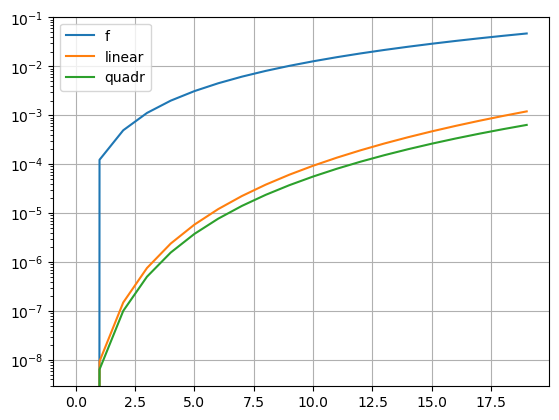

In [16]:
  
w = cp.random.random(w.shape).astype('float32')*mask
dw0 = cp.random.random(w.shape).astype('float32')/10*mask
v = cp.random.random(3).astype('float32')
dv0 = cp.random.random(3).astype('float32')/10
phi = cp.random.random(2).astype('float32')
dphi0 = cp.random.random(2).astype('float32')/3

l = cp.linspace(0,1,20).astype('float32')
err1 = np.zeros(20)
err2 = np.zeros(20)
err3 = np.zeros(20)
for k in range(20):
    dphi = l[k]*dphi0
    dw = 0*dw0
    a = F22([w,phi+dphi])    
    a1 = F22([w,phi])    
    err1[k] = cp.linalg.norm(a1[0]-a[0])**2+cp.linalg.norm(a1[1]-a[1])**2
    a2 = dF22([w,phi],[dw,dphi])
    err2[k] = cp.linalg.norm(a1[0]+a2[0]-a[0])**2+cp.linalg.norm(a1[1]+a2[1]-a[1])**2
    a3 = d2F22([w,phi],[dw,dphi],[dw,dphi])
    err3[k] = cp.linalg.norm(a1[0]+a2[0]+0.5*a3[0]-a[0])**2+cp.linalg.norm(a1[1]+a2[1]+0.5*a3[1]-a[1])**2    
plt.plot(err1,label='f')
plt.plot(err2,label='linear')
plt.plot(err3,label='quadr')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

## Adjoint test for the gradient

In [17]:
w = cp.random.random(w_shape).astype('float32')
phi = cp.random.random(2).astype('float32')
dw = cp.random.random(w_shape).astype('float32')/4
dphi = cp.random.random(2).astype('float32')/4

a = dF22([w,phi],[dw,dphi])
b = dF22adj([w,phi], a)

print(cp.sum(a[0]*a[0])+cp.sum(a[1]*a[1]))
print(cp.sum(dw*b[0])+cp.sum(dphi*b[1]))


16382.221656315756
16382.222


### $F_3(w,a) = \|M(|w|-a)\|_2^2$

In [18]:
def F3(x):
    w,a = x
    w_abs = cp.linalg.norm(w, axis=-1)
    return cp.linalg.norm(mask[...,0]*(w_abs-a))**2

def dF3(x,y):
    w,a = x
    dw,da = y
    
    w_abs = cp.linalg.norm(w, axis=-1)
    n_one = w_abs*0+1
    
    t1 = 2*cp.sum((w-a*w/(w_abs[...,cp.newaxis]+1e-7))*dw*mask)
    t2 = -2*cp.sum(w_abs*mask[...,0])*da
    t3 = 2*a*da*cp.linalg.norm(n_one*mask[...,0])**2
    return t1+t2+t3
    
def d2F3(x,y,z):
    w,a = x
    dw1,da1 = y
    dw2,da2 = z

    
    w_abs = cp.linalg.norm(w, axis=-1)
    n_one = w_abs*0+1
    w_hat = w/(w_abs[...,cp.newaxis]+1e-7)

    t1 = cp.linalg.norm(n_one*mask[...,0])**2*da1*da2
    t2 = -cp.sum(w_hat*dw1*mask)*da2
    t3 = -cp.sum(w_hat*dw2*mask)*da1
    
    dw1dw2 = cp.sum(dw1*dw2*mask,axis=-1)
    t4 = cp.sum((1-a/(w_abs+1e-7))*dw1dw2*mask[...,0])

    wdw1 = cp.sum(w_hat*dw1,axis=-1)
    wdw2 = cp.sum(w_hat*dw2,axis=-1)

    t5 = cp.sum(a/(w_abs+1e-7)*wdw1*wdw2*mask[...,0])

    return 2*(t1+t2+t3+t4+t5)

def dF3adj(x,y):
    w,a = x
    
    w_abs = cp.linalg.norm(w, axis=-1)
    n_one = w_abs*0+1
    dw = 2*(w-a*w/(w_abs[...,cp.newaxis]+1e-7)) * mask * y
    da = (-2*cp.sum(w_abs*mask[...,0]) + 2*a*cp.linalg.norm(n_one*mask[...,0])**2) * y

    return [dw,da]    


# Adjoin test

In [19]:
w = cp.random.random(w_shape).astype('float32')
a = cp.random.random(1).astype('float32')
dw = cp.random.random(w_shape).astype('float32')/4
da = cp.random.random(1).astype('float32')/4

t = dF3([w,a],[dw,da])
tt = dF3adj([w,a], t)

print(cp.sum(t*t))
print(cp.sum(dw*tt[0])+cp.sum(da*tt[1]))

# s

104671.2
104671.25


# Approximation test

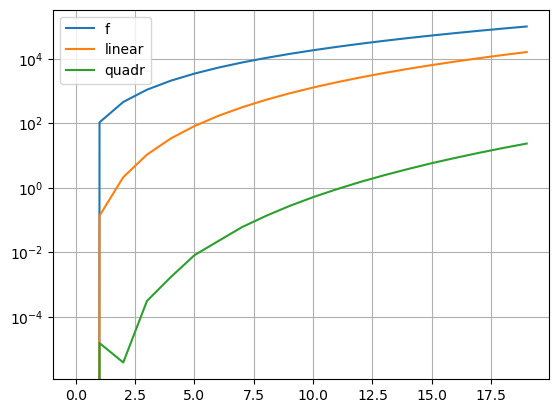

In [20]:
  
w = cp.random.random(w.shape).astype('float32')
dw0 = cp.random.random(w.shape).astype('float32')/10
a = cp.random.random(1).astype('float32')
da0 = cp.random.random(1).astype('float32')/10

l = cp.linspace(0,1,20).astype('float32')
err1 = np.zeros(20)
err2 = np.zeros(20)
err3 = np.zeros(20)
for k in range(20):
    dw = l[k]*dw0
    da = l[k]*da0
    t = F3([w+dw,a+da])    
    t1 = F3([w,a])    
    err1[k] = cp.linalg.norm(t1-t)**2
    t2 = dF3([w,a],[dw,da])
    err2[k] = cp.linalg.norm(t1+t2-t)**2
    # print(cp.linalg.norm(dF3([w,v],[dw,0*da])),cp.linalg.norm(dF3([w,v],[0*dw,da])))
    t3 = d2F3([w,a],[dw,da],[dw,da])
    err3[k] = cp.linalg.norm(t1+t2+0.5*t3-t)**2
plt.plot(err1,label='f')
plt.plot(err2,label='linear')
plt.plot(err3,label='quadr')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()


## Gradients and hessians

In [21]:
def gradient(vars,lam,d):
    w,phi,a = vars['w'],vars['phi'],vars['a']

    # first term
    gw = dF1adj(w,1)
    
    # second part
    gw0,gphi = dF22adj([w,phi],dF21adj(F22([w,phi]),1))    
    
    # third part 
    gw1,ga = dF3adj([w,a],1)
        
    # result
    grads = {}
    grads['w'] = gw + lam[0]*gw0 + lam[1]*gw1
    grads['phi'] = lam[0]*gphi
    grads['a'] = lam[1]*ga
    return grads

def hessian(vars,grads,etas,lam):
    w,phi,a = vars['w'],vars['phi'],vars['a']
    dw1,dphi1,da1 = grads['w'],grads['phi'],grads['a']
    dw2,dphi2,da2 = etas['w'],etas['phi'],etas['a']

    # first term
    t1 = d2F1(w,dw1,dw2)
    
    # second term, cascade
    x = [w,phi]
    y = [dw1,dphi1]
    z = [dw2,dphi2]    
    t2 = d2F21(F22(x),dF22(x,y),dF22(x,z))+dF21(F22(x),d2F22(x,y,z))
    
    # third term
    t3 = d2F3([w,a],[dw1,da1],[dw2,da2])
    
    return t1+lam[0]*t2+lam[1]*t3


# debug functions

In [ ]:
def calc_err(w,phi,a,lam):
    return F1(w)+lam[0]*(F21(F22([w,phi])))+lam[1]*F3([w,a])

def plot_debug(vars, etas, top, bottom, alpha, lam):
    """Checking second order approximation"""
    w, phi,a = vars['w'],vars['phi'],vars['a']
    weta, phieta, aeta = etas['w'],etas['phi'],etas['a']
    npp = 9
    errt = cp.zeros(npp * 2)
    errt2 = cp.zeros(npp * 2)
    for k in range(0, npp * 2):
        wt = w + (alpha * k / (npp - 1)) * weta
        phit = phi + (alpha * k / (npp - 1)) * phieta
        at = a + (alpha * k / (npp - 1)) * aeta
        errt[k] = calc_error(wt,phit,at,lam)
        
    t = alpha * (cp.arange(2 * npp)) / (npp - 1)
    errt2 = calc_error(w,phi,a,lam)
    errt2 = errt2 - top * t + 0.5 * bottom * t**2
    
    print(f'{phi=},{a=}')
    plt.plot(t.get(),errt.get(),".",label="real")
    plt.plot(t.get(),errt2.get(),".",label="approx")
    plt.legend()
    plt.grid()
    plt.show()


def vis_debug(vars):
    print(f'{vars['phi']=}')
    print(f'{vars['a']=}')
    mshow_complex(vars['w'][w_shape[0]//2,:,:,0]+1j*vars['w'][w_shape[0]//2,:,:,1])
    mshow_complex(vars['w'][:,w_shape[1]//2,:,0]+1j*vars['w'][:,w_shape[1]//2,:,1])
    mshow(np.linalg.norm(vars['w'][w.shape[0]//2],axis=-1),True)


# BH 
### $\argmin_{w,\varphi,a} \|F_1(w)\|_2^2+\lambda_1\|F_{21}(F_{22}(w,\varphi))\|_2^2+\lambda_2\|F_{3}(w,a)\|_2^2   =\sum_\theta\|P_\theta(M(w))-d_\theta\|_2^2+\lambda_1\|M(w)\cdot \Theta(\varphi_1,\varphi_2)\|_2^2+\lambda_2\|M(|w|-a)\|_2^2$

In [23]:
def BH(vars, d, niter,lam):
    err = cp.zeros(niter)
    for i in range(niter):
        
        if i%16==0:
            err[i] = calc_err(vars,lam)
            print(i,f'err={err[i]}')
        grads = gradient(vars,lam,d)
        
        if i == 0:
            etas = {}
            etas['w'] = -grads['w']
            etas['phi'] = -grads['phi']
            etas['a'] = -grads['a']
        else:
            top = hessian(vars,grads,etas,lam)
            bottom = hessian(vars,etas,etas,lam)
            beta = top / bottom
            etas['w'] = etas['w'] * beta - grads['w']
            etas['phi'] = etas['phi'] * beta - grads['phi']
            etas['a'] = etas['a'] * beta - grads['a']            
            
        top = (-cp.sum(grads['w']*etas['w'])
               -cp.sum(grads['phi']*etas['phi'])
               -cp.sum(grads['a']*etas['a']))
        bottom = hessian(vars, etas, etas, lam)
        alpha = top / bottom
        # print(alpha,top,bottom)
        if i%64==0:
            plot_debug(vars,etas,top,bottom,alpha,lam)
        if i%64==0:
            vis_debug(vars)

        vars['w'] += alpha * etas['w']
        vars['phi'] += alpha * etas['phi']
        vars['a'] += alpha * etas['a']       
    return vars,err


0 err=14350.779296875
phi=array([1., 1.], dtype=float32),a=np.float32(0.0)


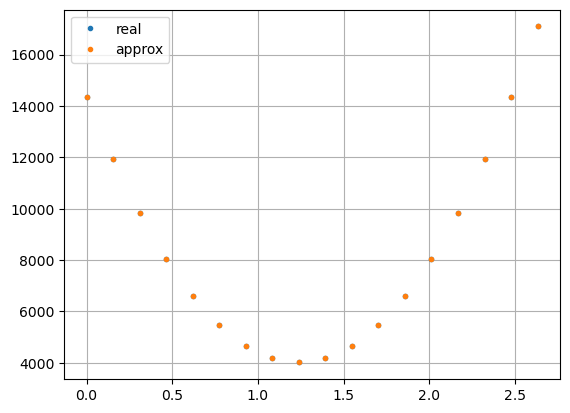

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=np.float32(0.0)


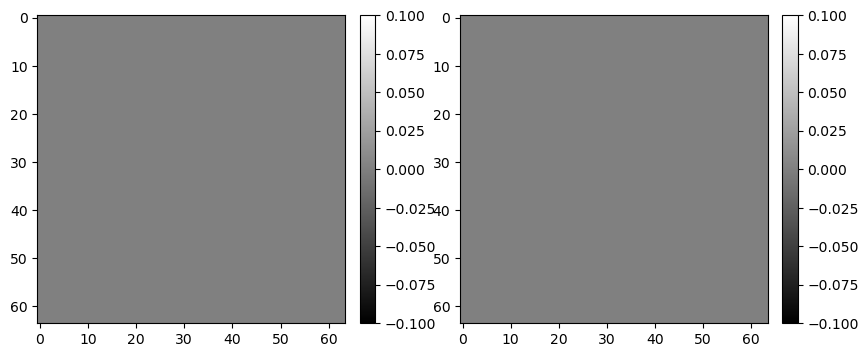

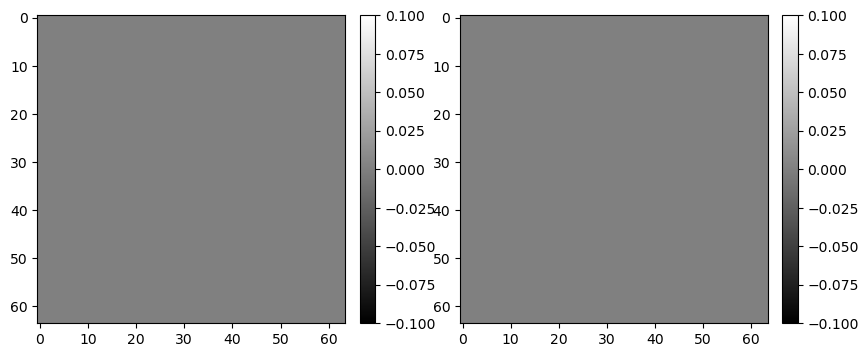

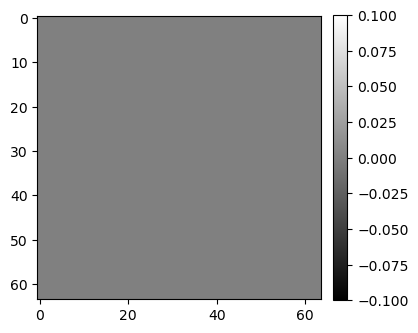

16 err=74.76386387941707
32 err=18.858745723143194
48 err=15.700779100347413
64 err=9.57379764606025
phi=array([ 1.7914631 , -0.02899994], dtype=float32),a=array(0.97429188)


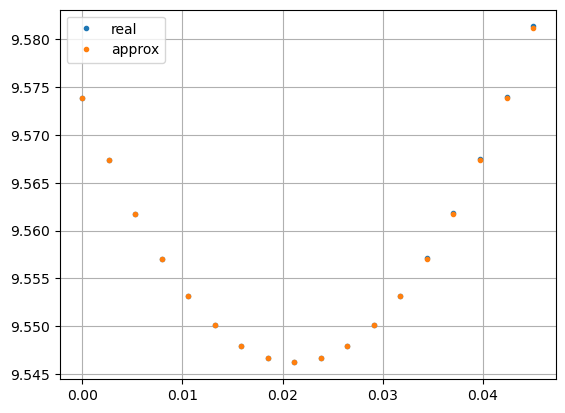

vars['phi']=array([ 1.7914631 , -0.02899994], dtype=float32)
vars['a']=array(0.97429188)


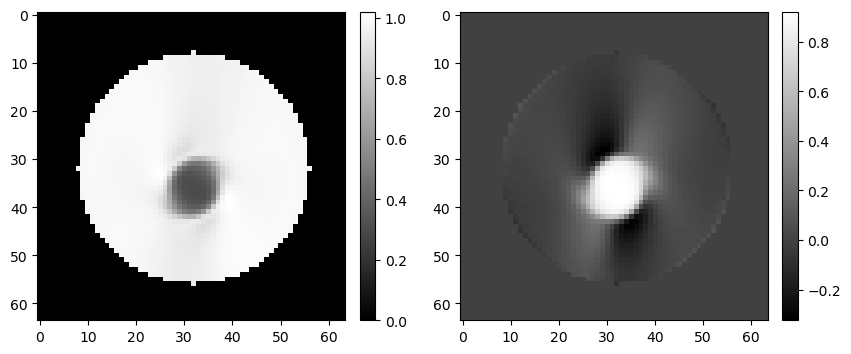

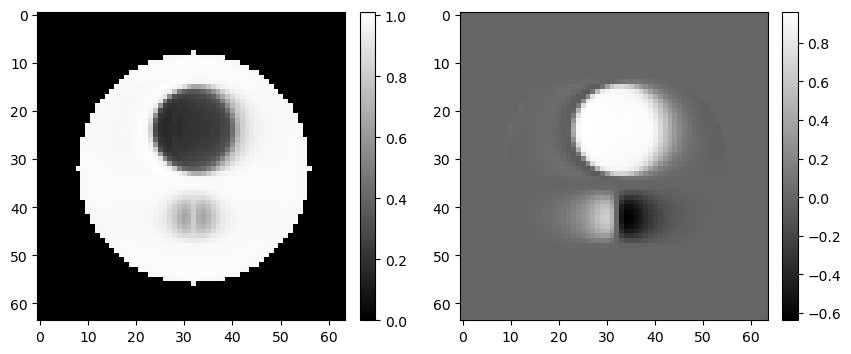

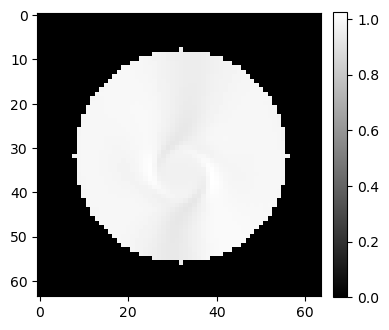

80 err=9.312739689893068
96 err=8.964209231314767
112 err=8.105479929428046
128 err=7.909482585768011
phi=array([ 1.7819146 , -0.05628093], dtype=float32),a=array(0.9804641)


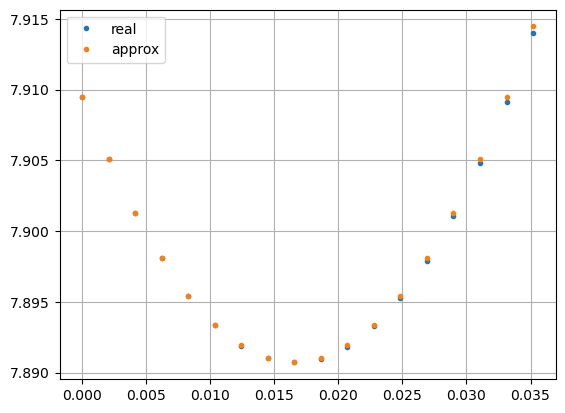

vars['phi']=array([ 1.7819146 , -0.05628093], dtype=float32)
vars['a']=array(0.9804641)


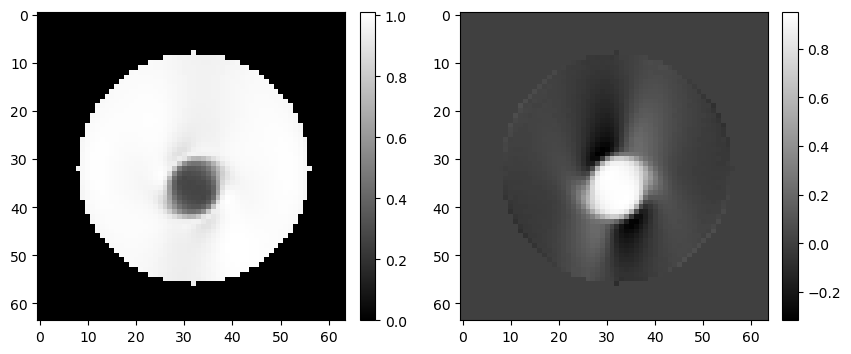

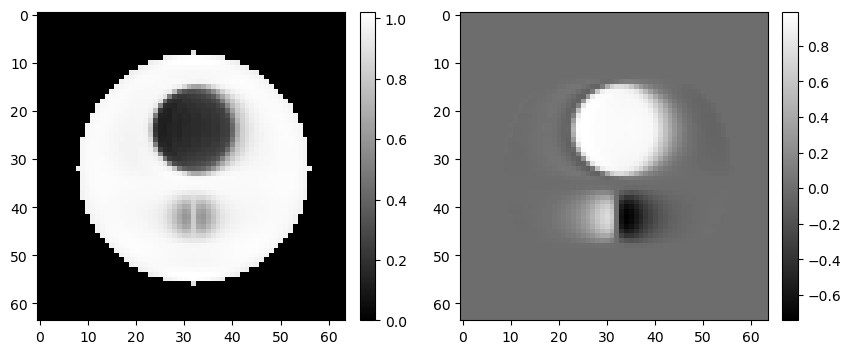

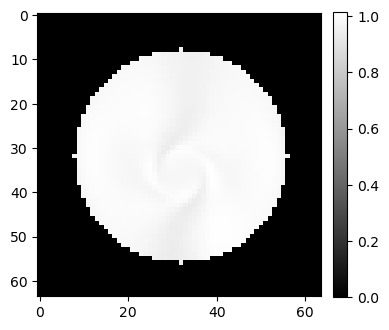

144 err=7.755382130059768
160 err=7.095732510177916
176 err=6.9211183301578245
192 err=6.786823739332958
phi=array([ 1.777423  , -0.09518603], dtype=float32),a=array(0.99283525)


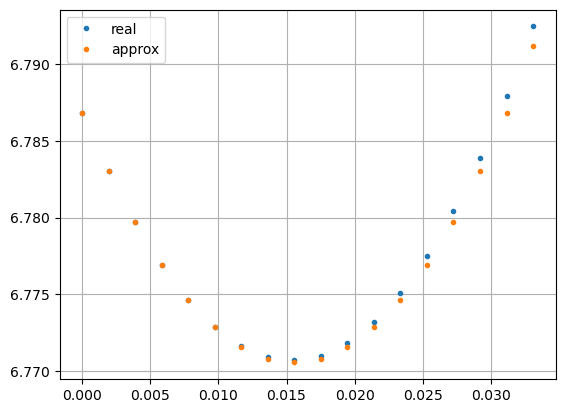

vars['phi']=array([ 1.777423  , -0.09518603], dtype=float32)
vars['a']=array(0.99283525)


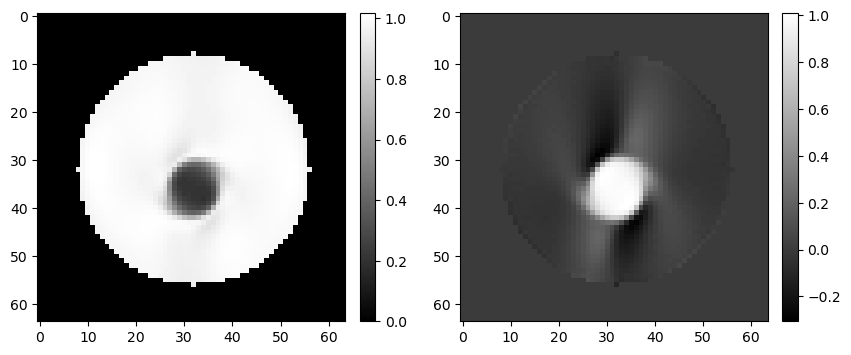

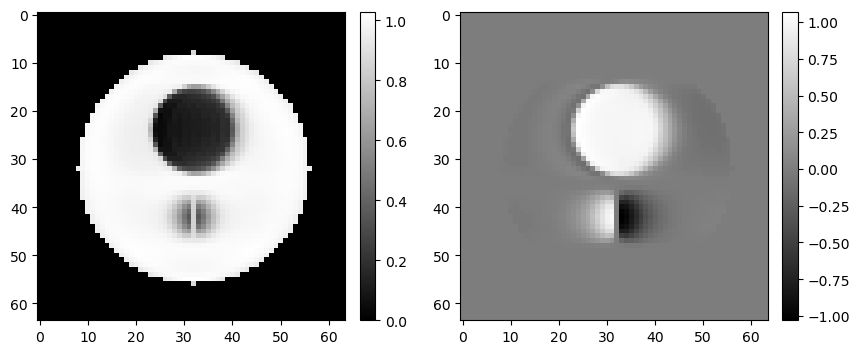

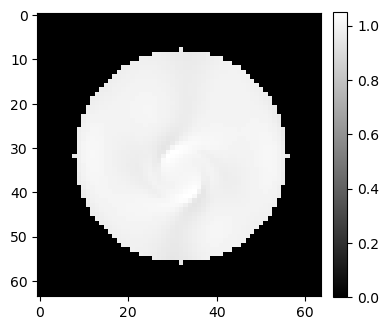

208 err=6.654921198945184
224 err=6.520968424852709
240 err=6.3961967530534185
256 err=6.295622517732978
phi=array([1.748611  , 0.00491599], dtype=float32),a=array(1.00680406)


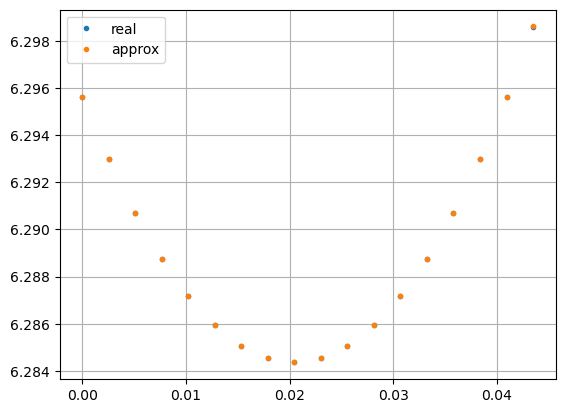

vars['phi']=array([1.748611  , 0.00491599], dtype=float32)
vars['a']=array(1.00680406)


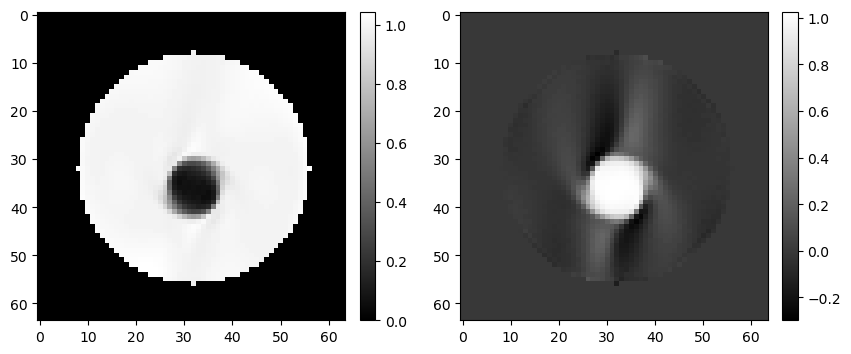

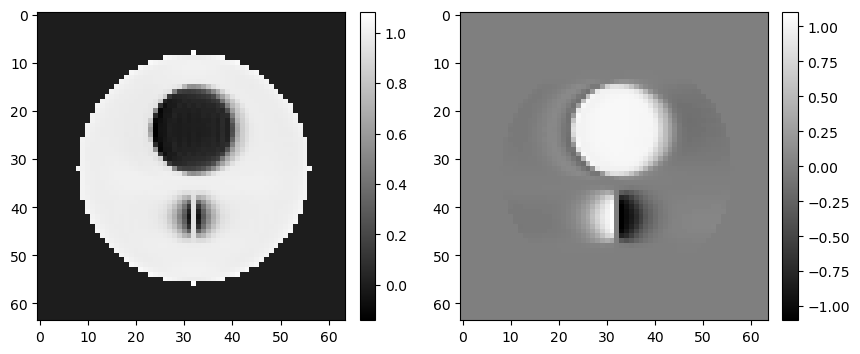

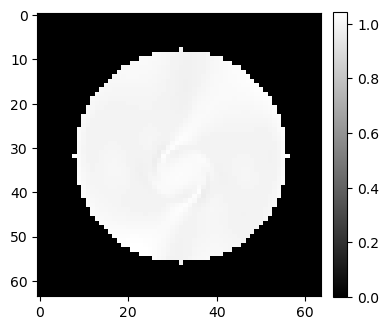

272 err=6.203229280717669
288 err=6.110985977642708
304 err=6.013091962081772
320 err=5.904481902571936
phi=array([1.7098829 , 0.09635799], dtype=float32),a=array(1.00248821)


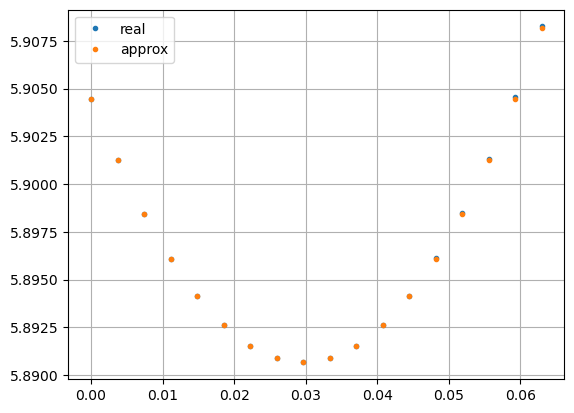

vars['phi']=array([1.7098829 , 0.09635799], dtype=float32)
vars['a']=array(1.00248821)


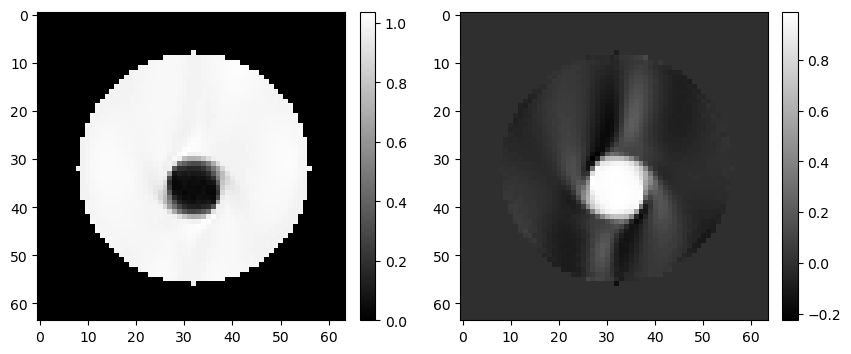

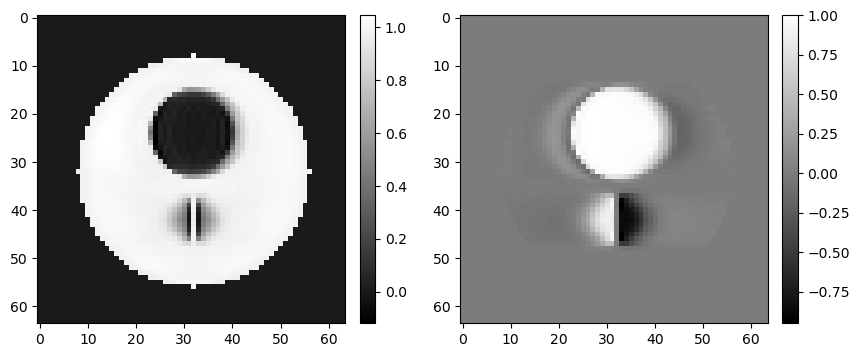

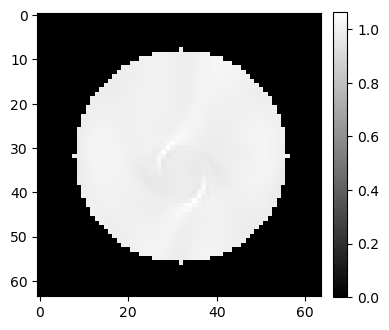

336 err=5.760897347147386
352 err=4.8195744741838755
368 err=4.751068934611582
384 err=4.684846991484369
phi=array([1.709628  , 0.07592358], dtype=float32),a=array(1.00496906)


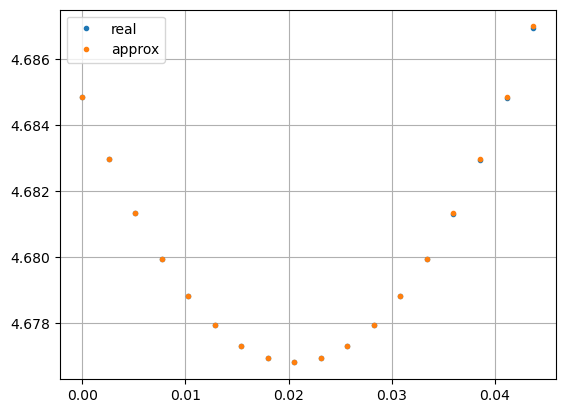

vars['phi']=array([1.709628  , 0.07592358], dtype=float32)
vars['a']=array(1.00496906)


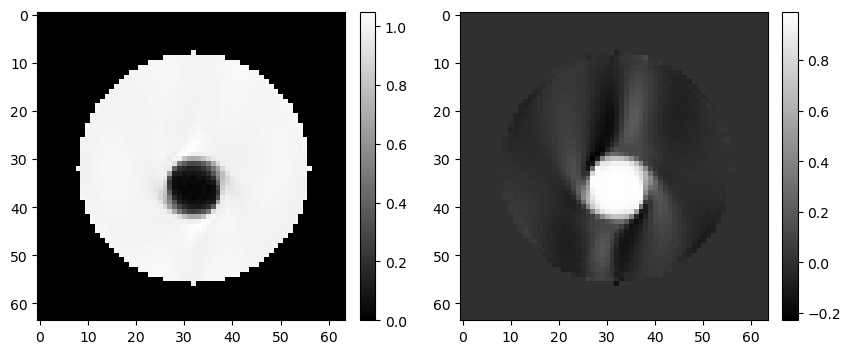

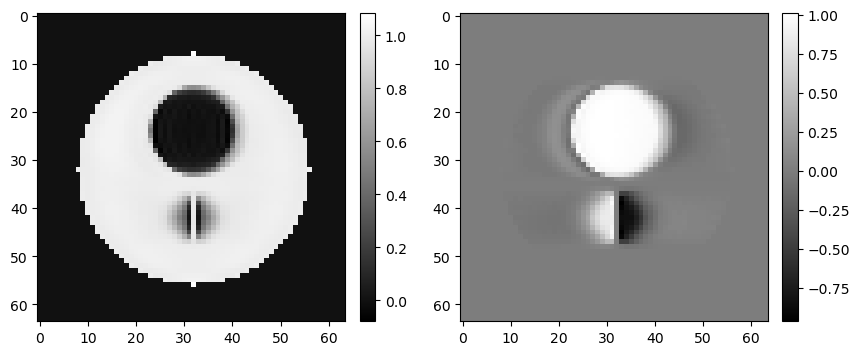

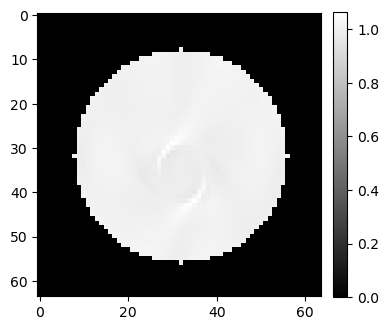

400 err=4.6132742828685975
416 err=4.527284905665775
432 err=4.445825267565907
448 err=4.3587214523066296
phi=array([ 1.7411412 , -0.02823036], dtype=float32),a=array(1.00226201)


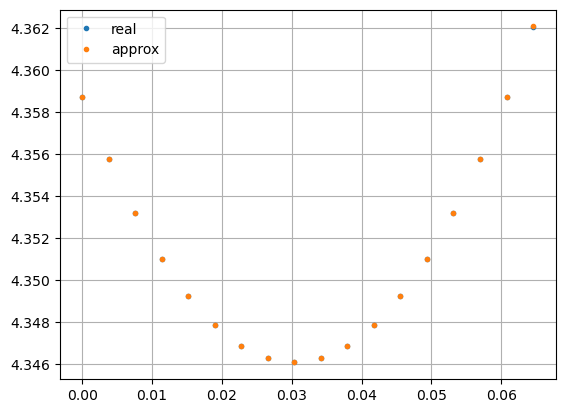

vars['phi']=array([ 1.7411412 , -0.02823036], dtype=float32)
vars['a']=array(1.00226201)


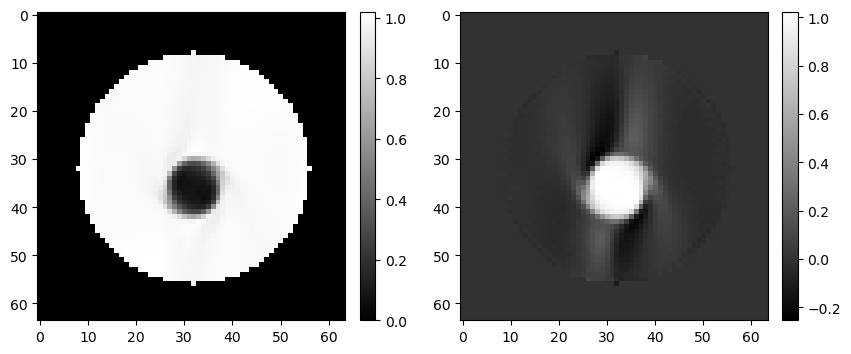

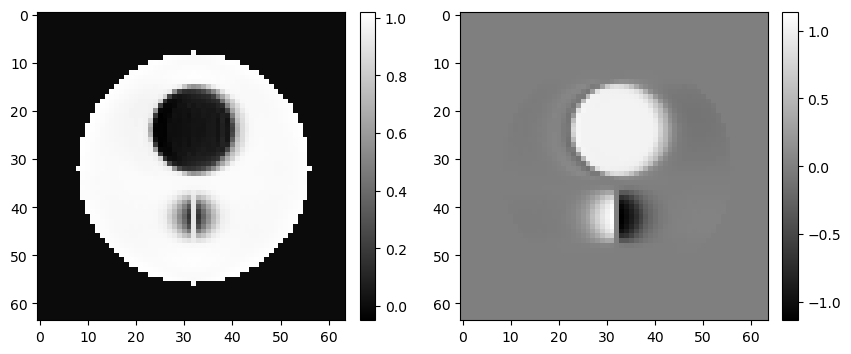

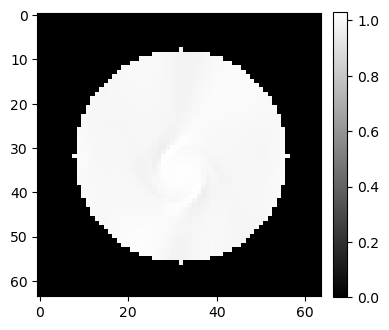

464 err=4.2442868527231585
480 err=4.020461631911967
496 err=2.948887387752743
512 err=2.8924811795913974
phi=array([ 1.7540690e+00, -4.0630647e-04], dtype=float32),a=array(0.99431852)


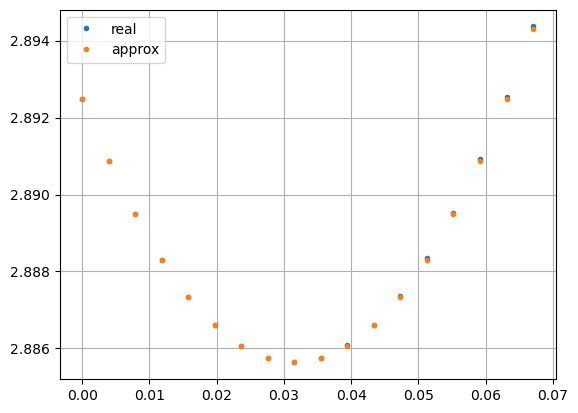

vars['phi']=array([ 1.7540690e+00, -4.0630647e-04], dtype=float32)
vars['a']=array(0.99431852)


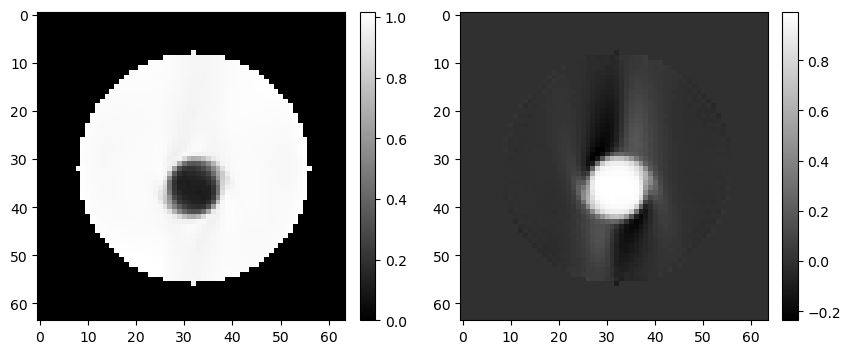

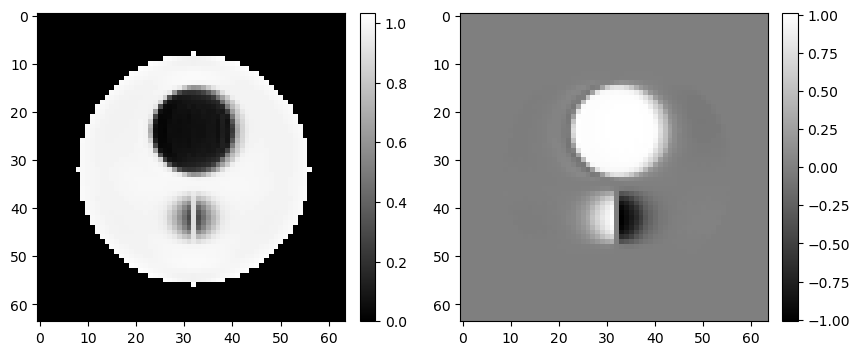

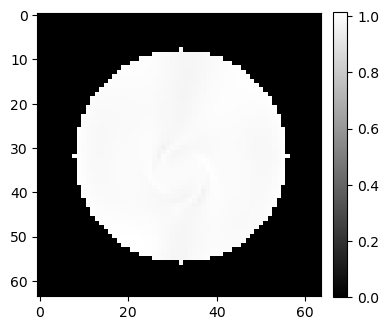

528 err=2.8334261971460863
544 err=2.7518838163720423
560 err=2.672281074783595
576 err=2.6083830016037335
phi=array([1.7338651 , 0.04277152], dtype=float32),a=array(1.00063664)


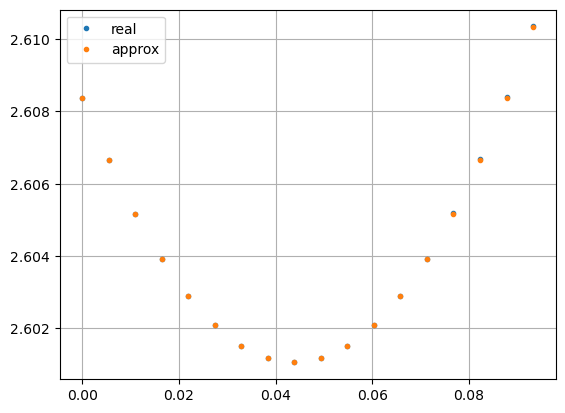

vars['phi']=array([1.7338651 , 0.04277152], dtype=float32)
vars['a']=array(1.00063664)


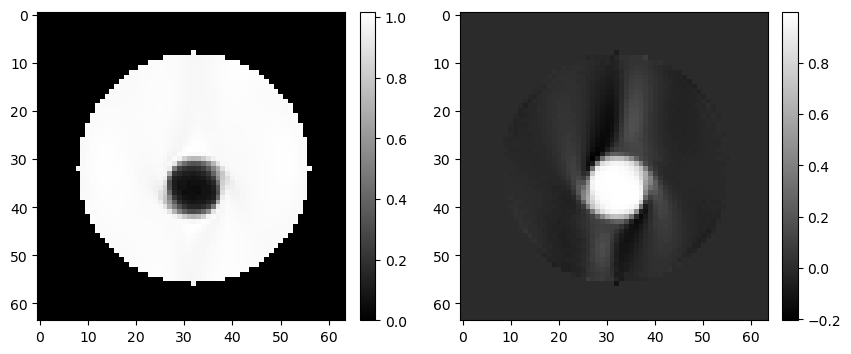

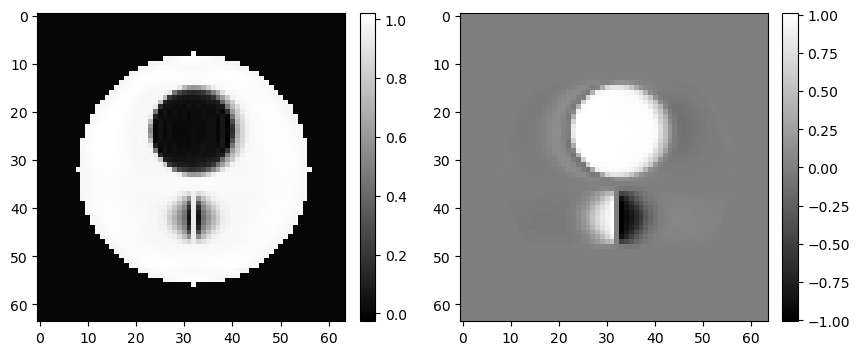

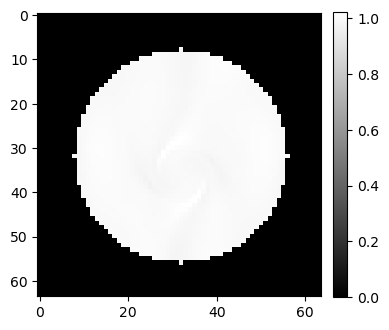

592 err=2.5510324864218044
608 err=2.4971865854521877
624 err=2.429585452465153
640 err=2.3364023470306083
phi=array([ 1.707152  , -0.06192883], dtype=float32),a=array(1.00316657)


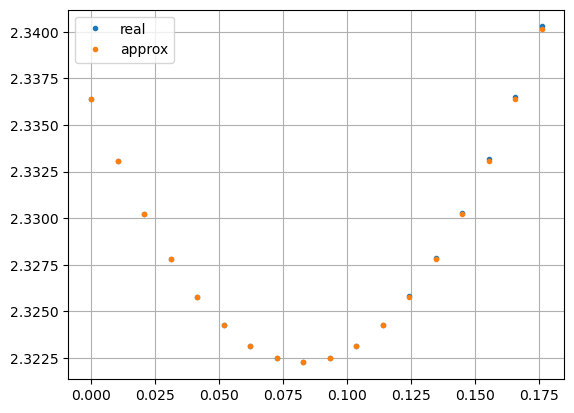

vars['phi']=array([ 1.707152  , -0.06192883], dtype=float32)
vars['a']=array(1.00316657)


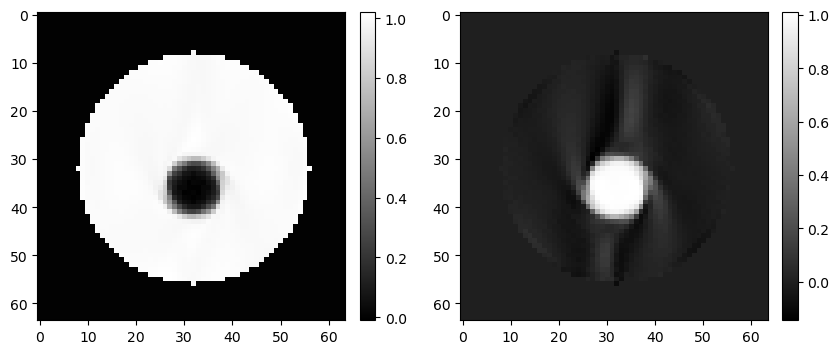

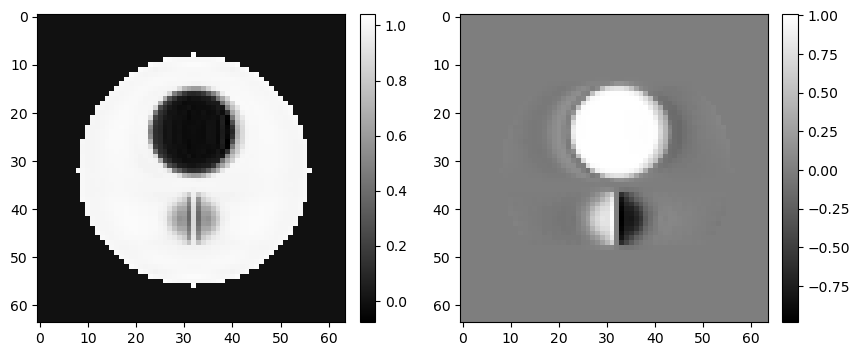

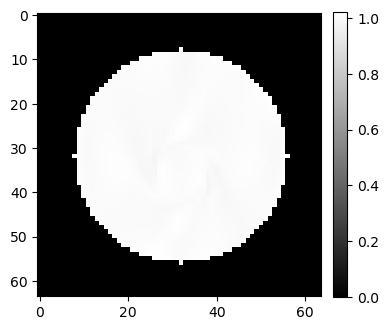

656 err=2.15127861030284
672 err=1.0335586833935737
688 err=0.9297765601944271
704 err=0.8986787410019222
phi=array([1.6714736 , 0.01023597], dtype=float32),a=array(0.99735185)


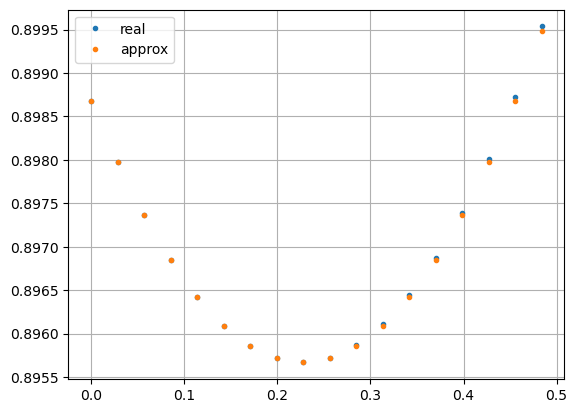

vars['phi']=array([1.6714736 , 0.01023597], dtype=float32)
vars['a']=array(0.99735185)


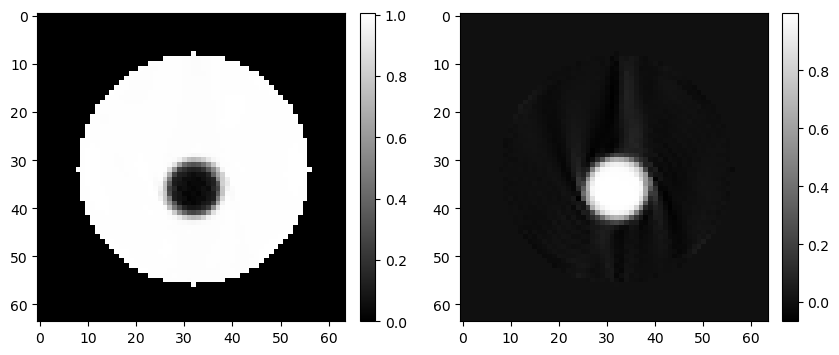

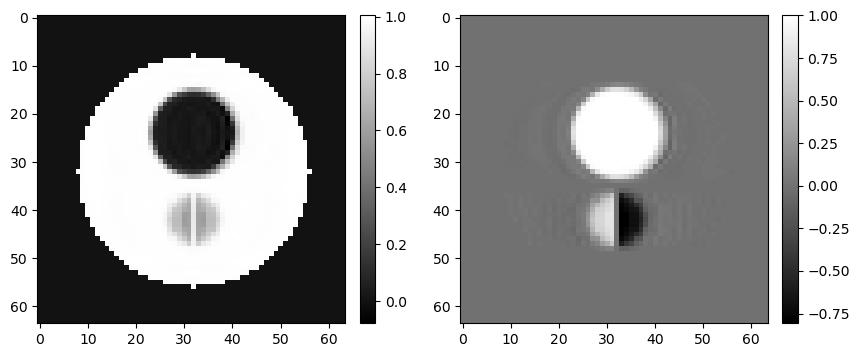

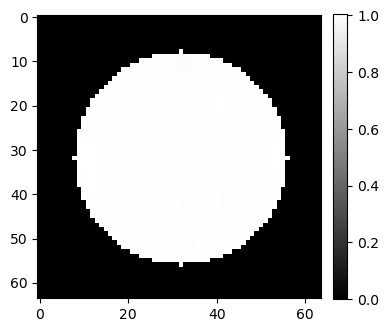

720 err=0.8627604434093564
736 err=0.7363459859268786
752 err=0.6641437642674382
768 err=0.5736975362208427
phi=array([1.6709139, 0.0069947], dtype=float32),a=array(0.99878878)


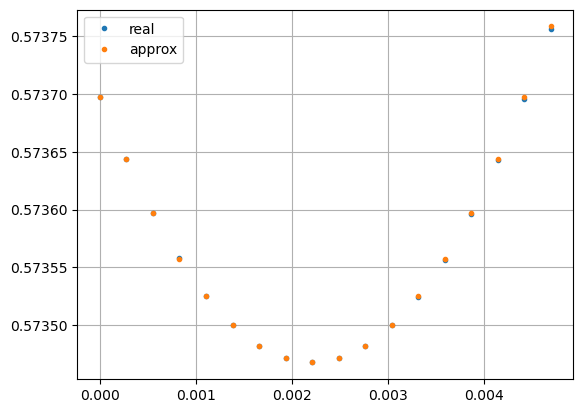

vars['phi']=array([1.6709139, 0.0069947], dtype=float32)
vars['a']=array(0.99878878)


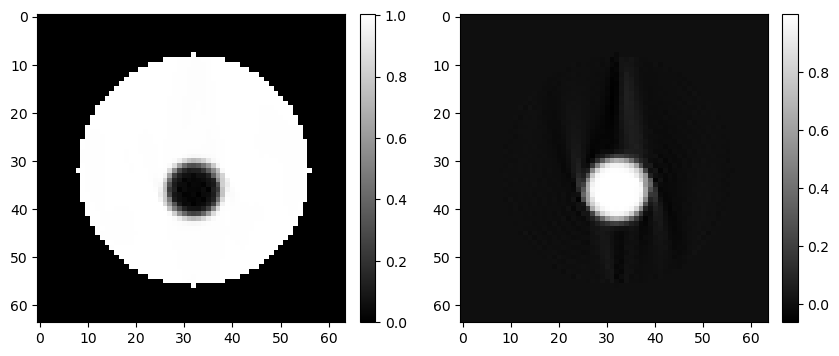

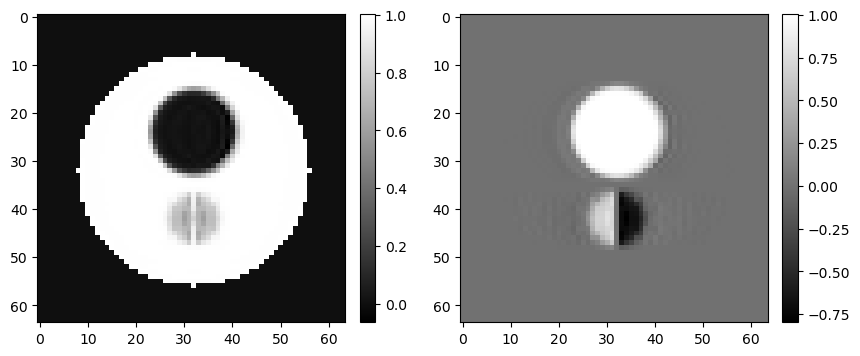

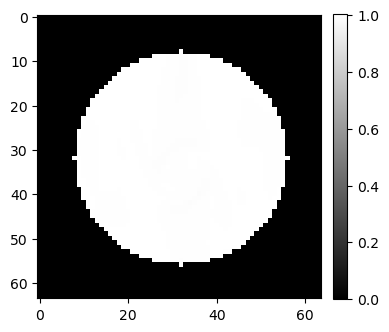

784 err=0.571589805600859
800 err=0.5691258947768683
816 err=0.5661020709554904
832 err=0.55061011512737
phi=array([ 1.67081   , -0.01598698], dtype=float32),a=array(0.99927908)


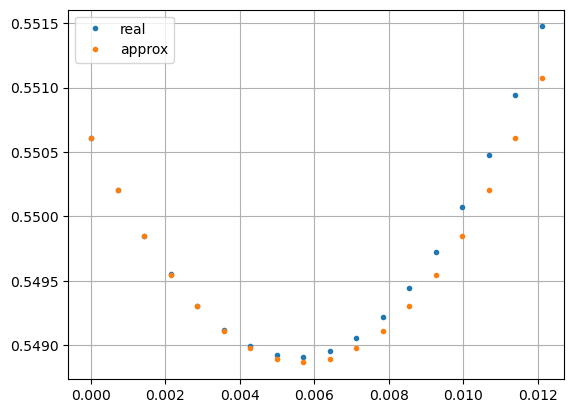

vars['phi']=array([ 1.67081   , -0.01598698], dtype=float32)
vars['a']=array(0.99927908)


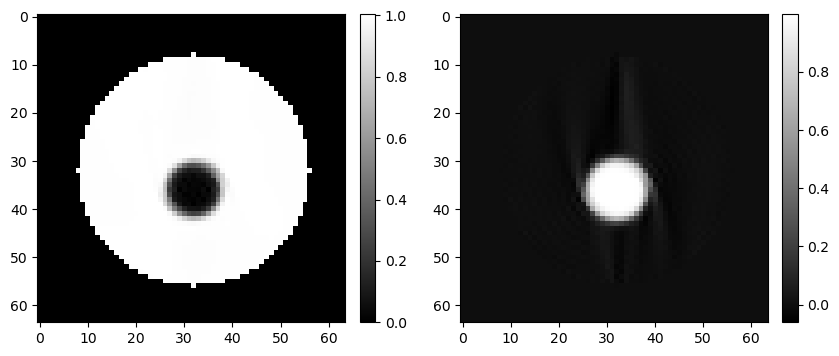

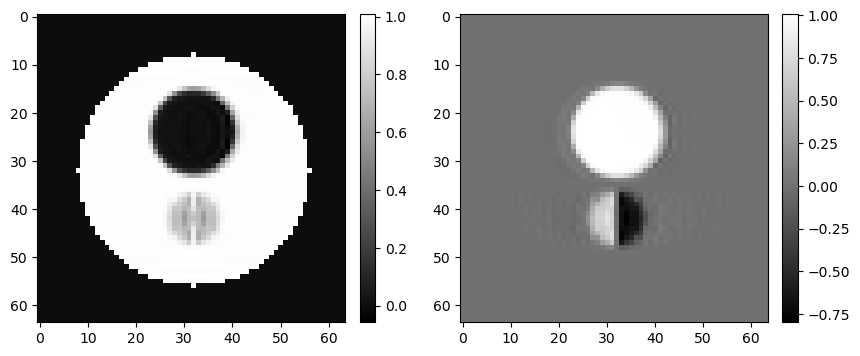

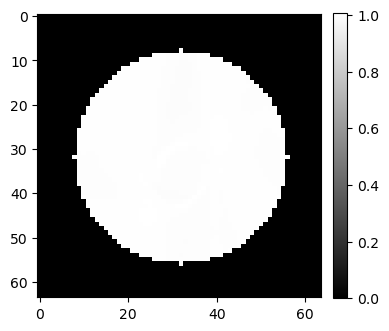

848 err=0.5374700682199525
864 err=0.5265029365932101
880 err=0.5131028278793085
896 err=0.5025839692967529
phi=array([1.6699601 , 0.00413748], dtype=float32),a=array(1.00038819)


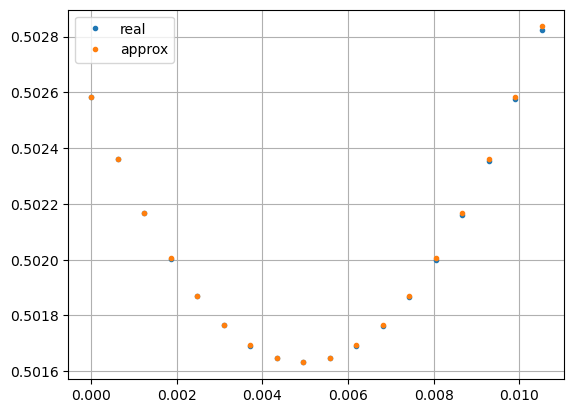

vars['phi']=array([1.6699601 , 0.00413748], dtype=float32)
vars['a']=array(1.00038819)


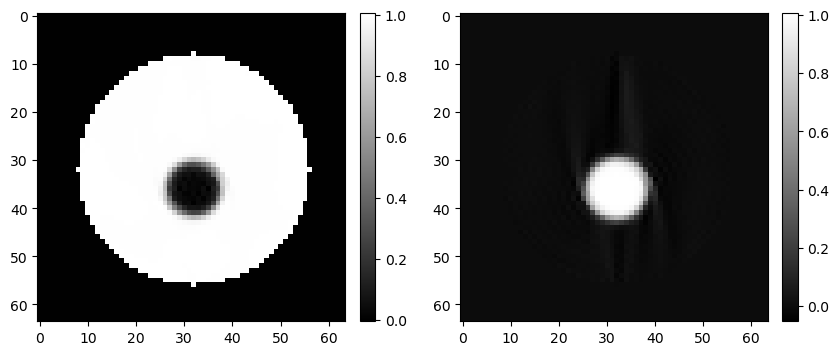

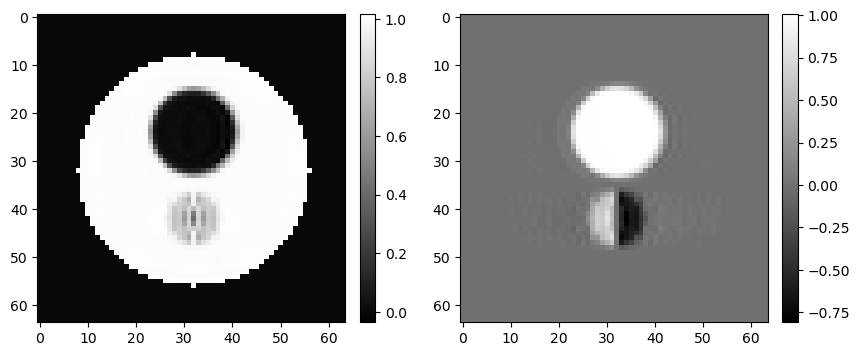

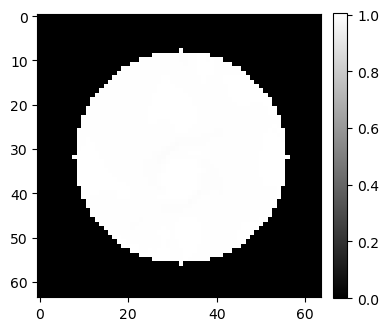

912 err=0.4957652172228717
928 err=0.49015767161283885
944 err=0.4857690706662063
960 err=0.4820788273438766
phi=array([1.6690892 , 0.02174142], dtype=float32),a=array(0.99966434)


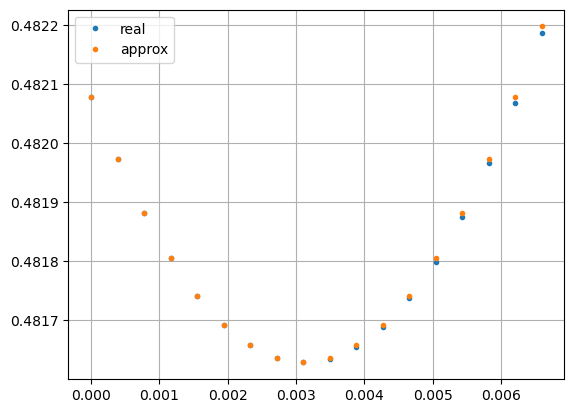

vars['phi']=array([1.6690892 , 0.02174142], dtype=float32)
vars['a']=array(0.99966434)


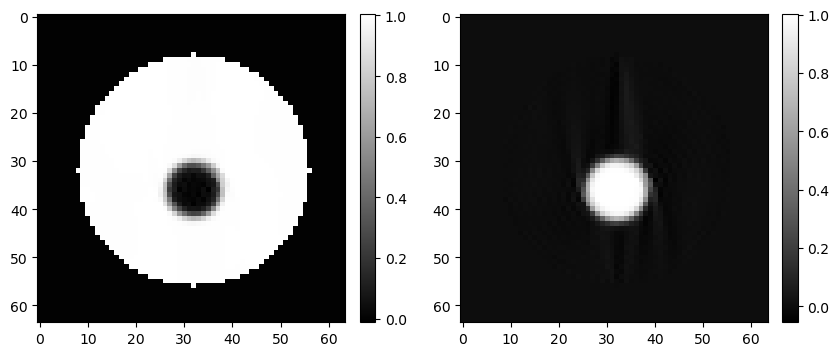

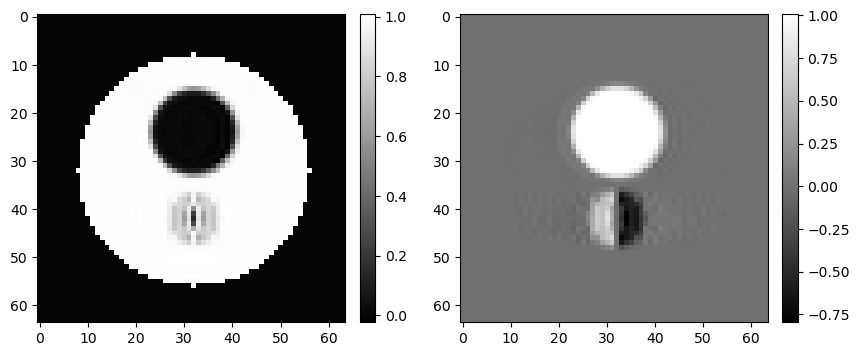

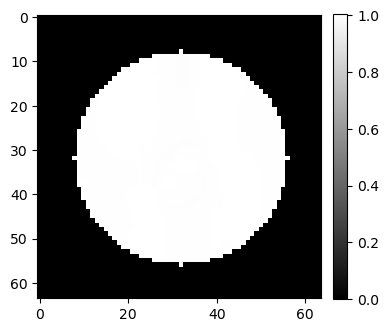

976 err=0.4781164865505596
992 err=0.47426983883242296
1008 err=0.4714376160400491


In [24]:
# initial guess
vars = {}
vars['w'] = w*0
vars['phi'] = cp.array([1,1],dtype='float32')
vars['a'] = cp.float32(0)
lam = [0.00001,0.1]
niter = 1024
vars,err2 = BH(vars,data,niter,lam)



0 err=14350.779296875
phi=array([1., 1.], dtype=float32),a=np.float32(0.0)


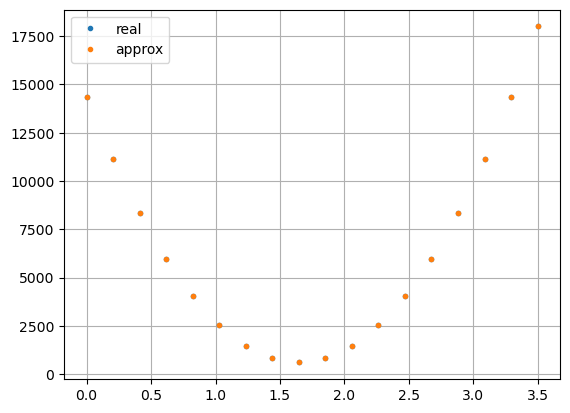

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=np.float32(0.0)


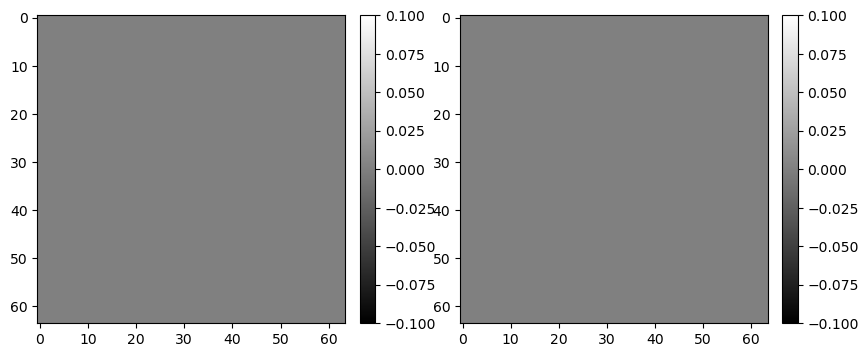

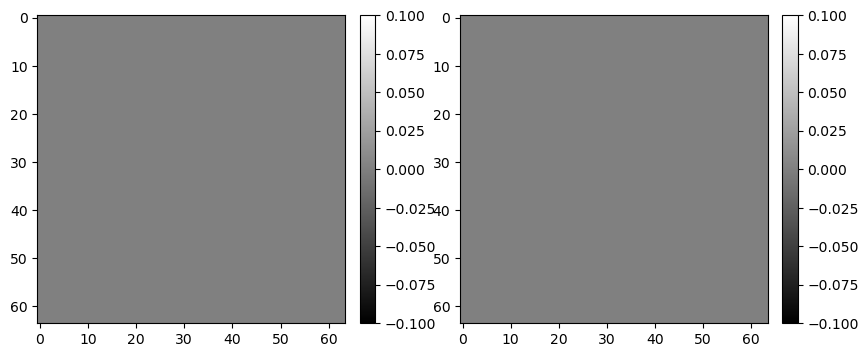

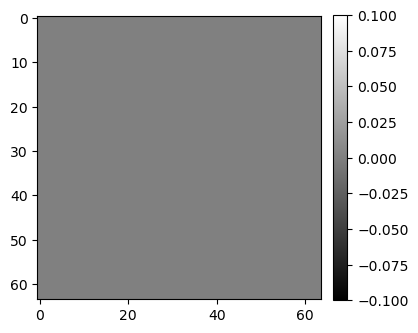

16 err=0.010445362888276577
32 err=0.0010717413388192654
48 err=0.0004940068465657532
64 err=0.0003420776629354805
phi=array([1., 1.], dtype=float32),a=array(0.)


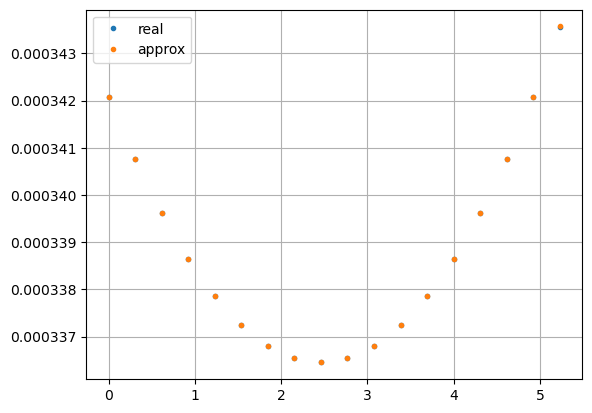

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


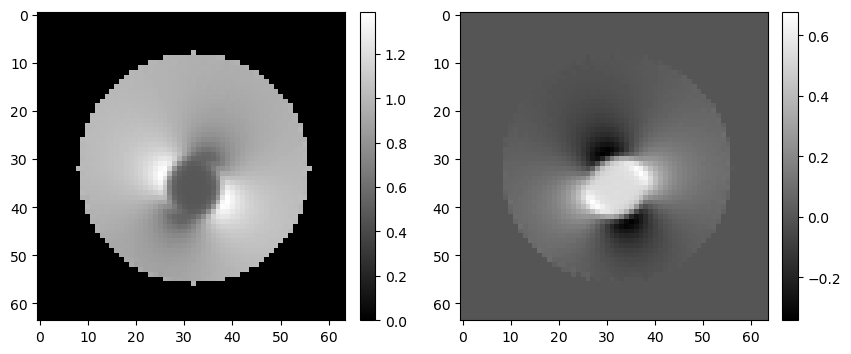

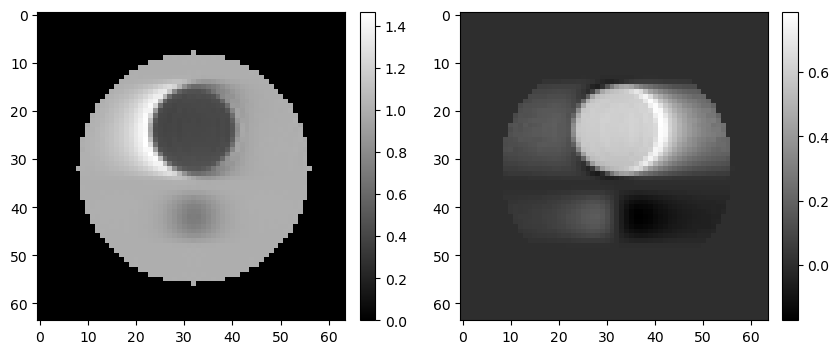

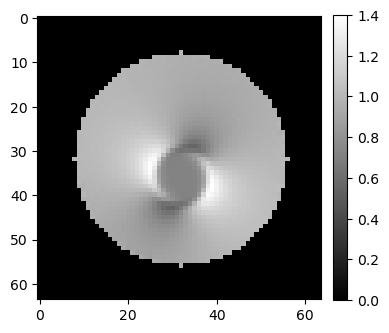

80 err=0.0002519722329452634
96 err=0.00018494496180210263
112 err=0.00013892658171243966
128 err=0.00011031423491658643
phi=array([1., 1.], dtype=float32),a=array(0.)


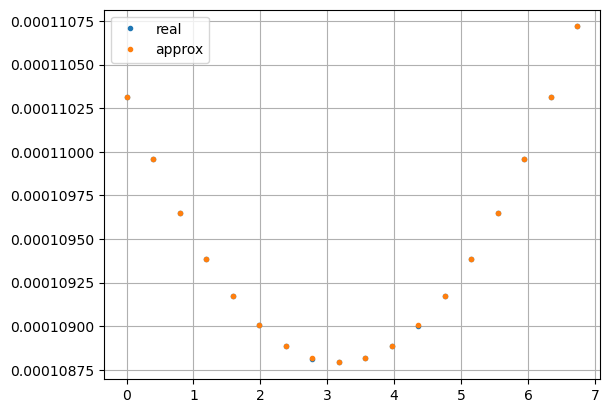

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


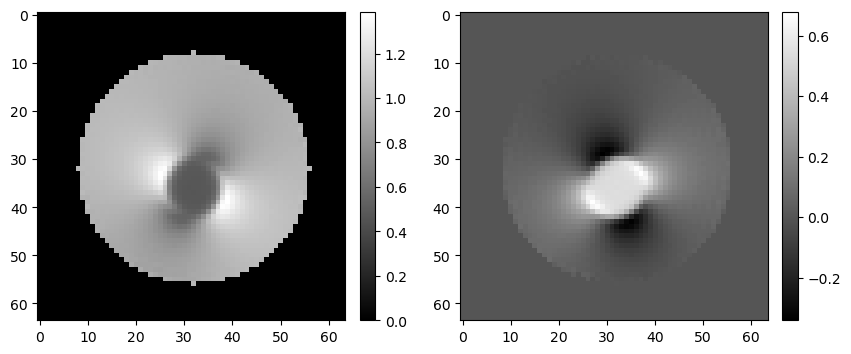

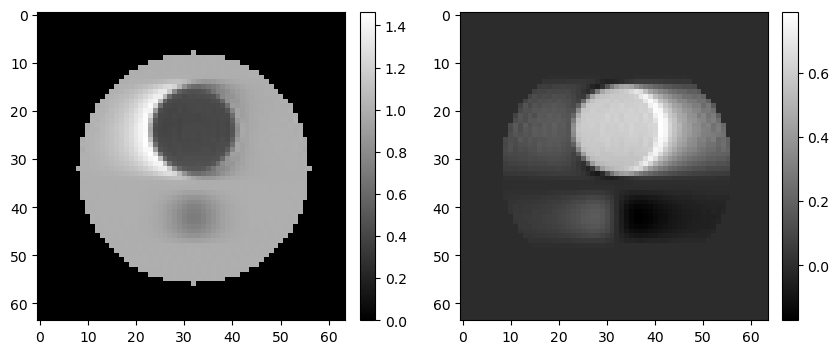

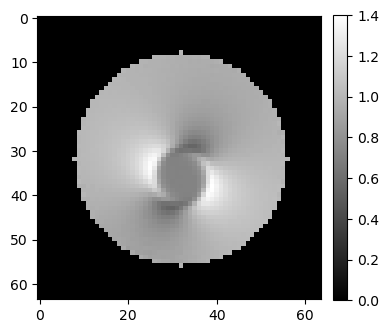

144 err=9.154103463515639e-05
160 err=7.842996274121106e-05
176 err=6.892115197842941e-05
192 err=6.078517253627069e-05
phi=array([1., 1.], dtype=float32),a=array(0.)


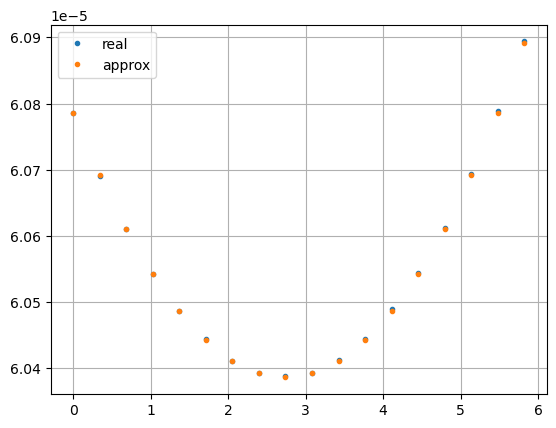

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


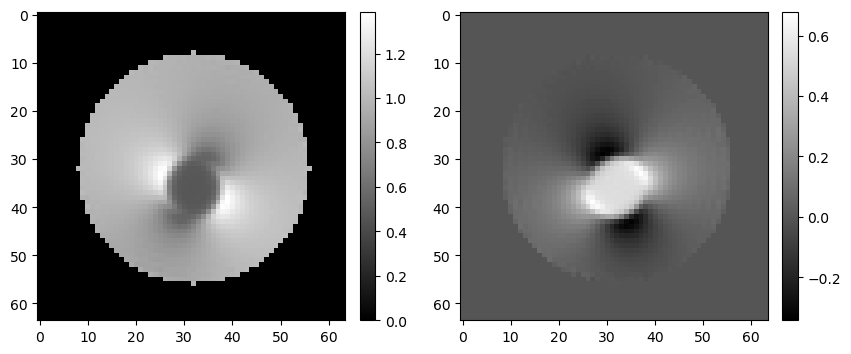

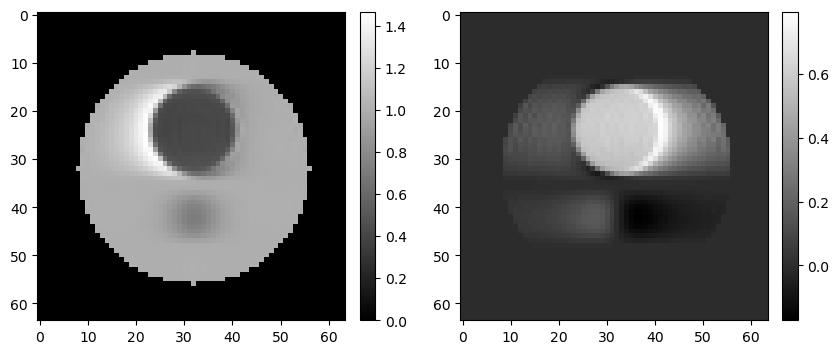

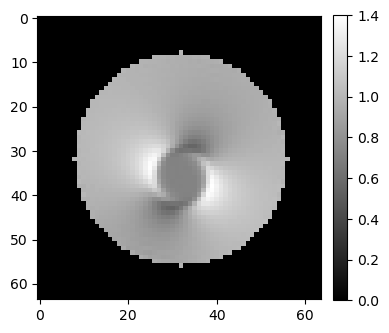

208 err=5.443890768219717e-05
224 err=4.899780833511613e-05
240 err=4.4811564293922856e-05
256 err=4.083160820300691e-05
phi=array([1., 1.], dtype=float32),a=array(0.)


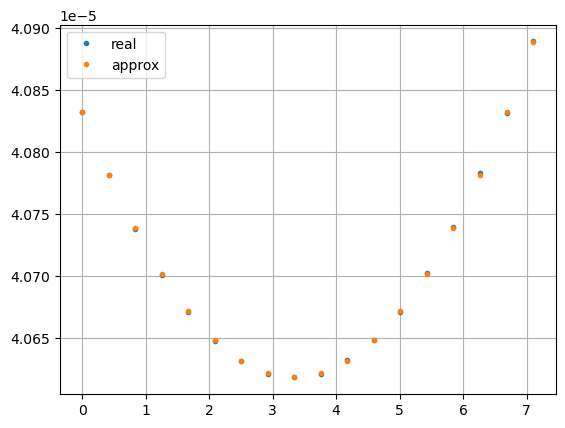

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


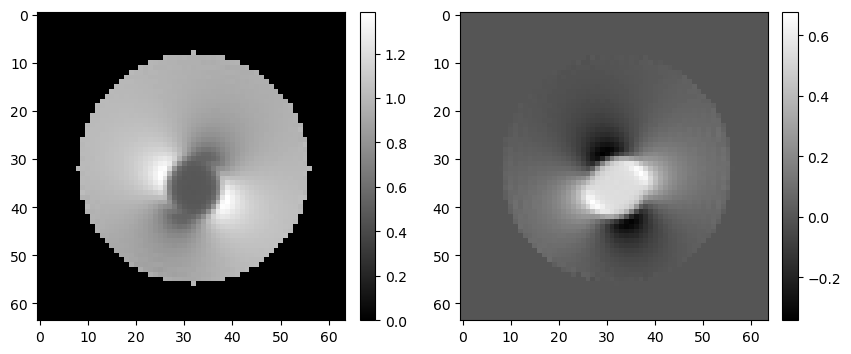

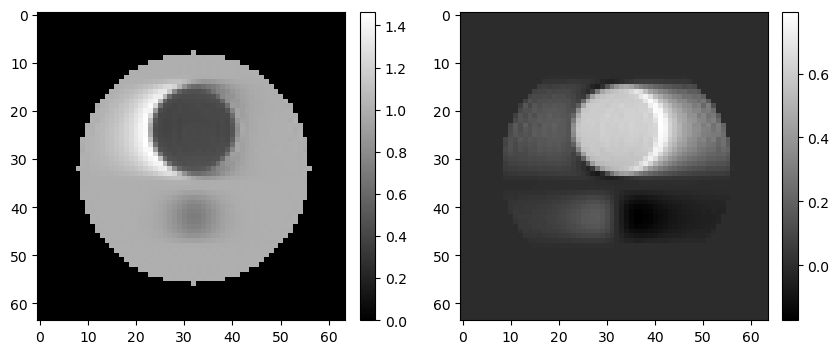

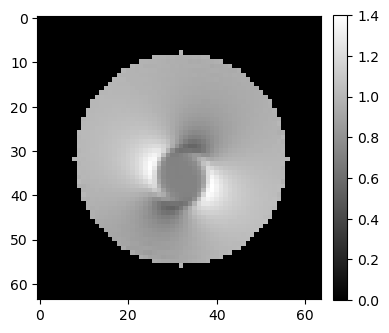

272 err=3.752554766833782e-05
288 err=3.404140443308279e-05
304 err=3.123667192994617e-05
320 err=2.855926322808955e-05
phi=array([1., 1.], dtype=float32),a=array(0.)


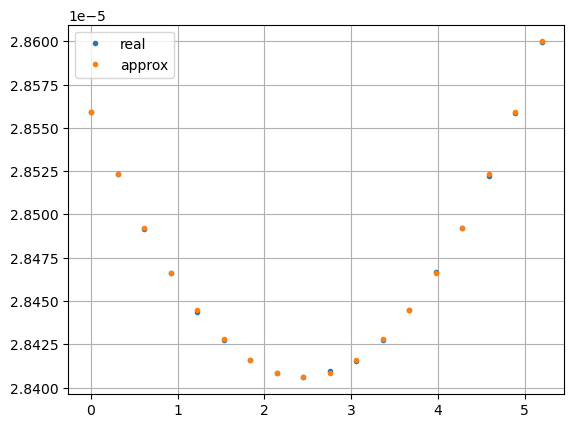

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


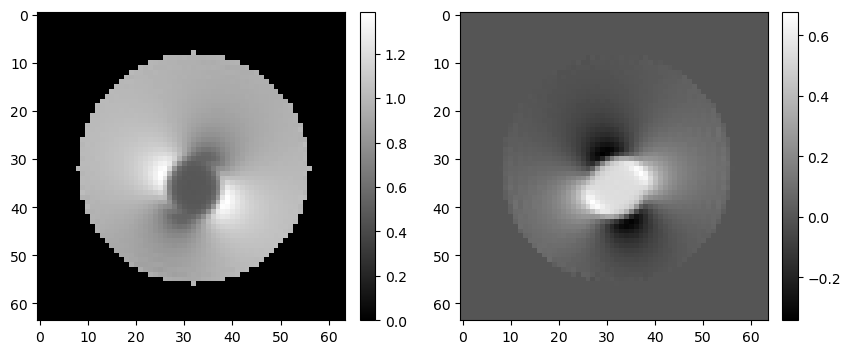

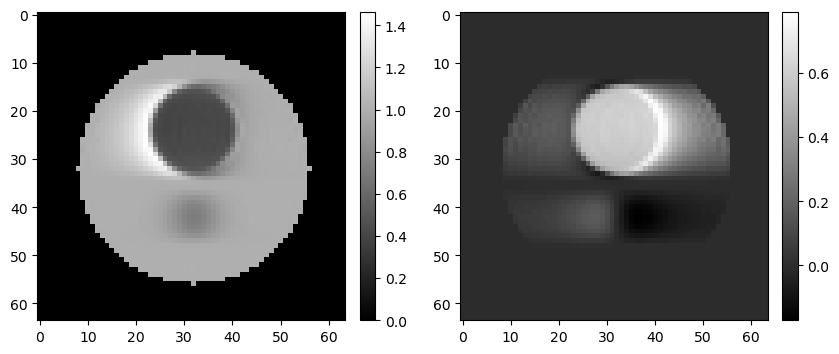

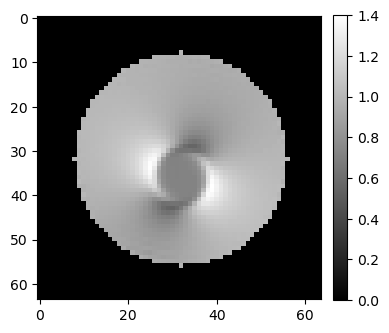

336 err=2.632954237924423e-05
352 err=2.422882243990898e-05
368 err=2.191079875046853e-05
384 err=2.0069408492418006e-05
phi=array([1., 1.], dtype=float32),a=array(0.)


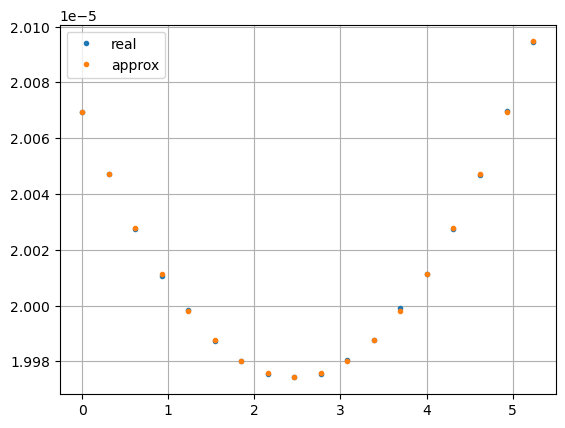

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


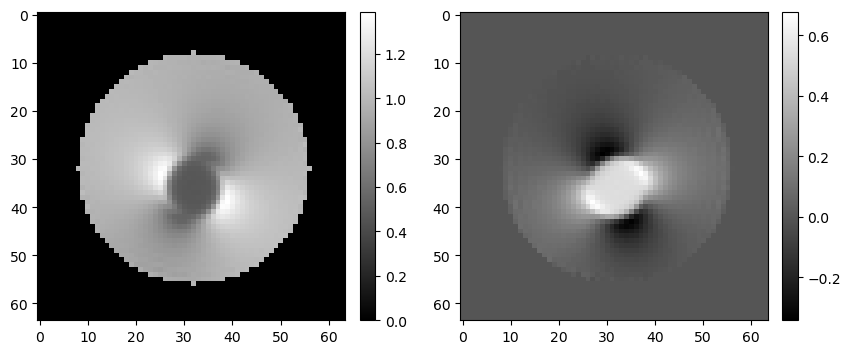

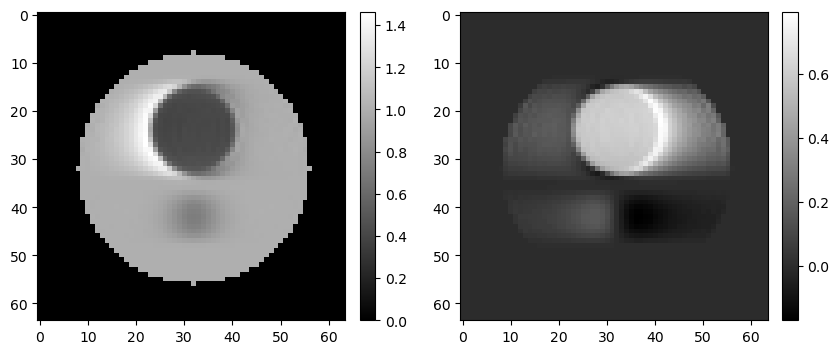

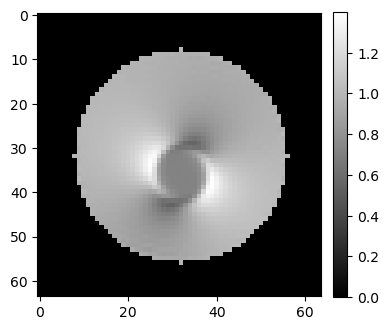

400 err=1.846546911110636e-05
416 err=1.6926311218412593e-05
432 err=1.578740557306446e-05
448 err=1.4752178685739636e-05
phi=array([1., 1.], dtype=float32),a=array(0.)


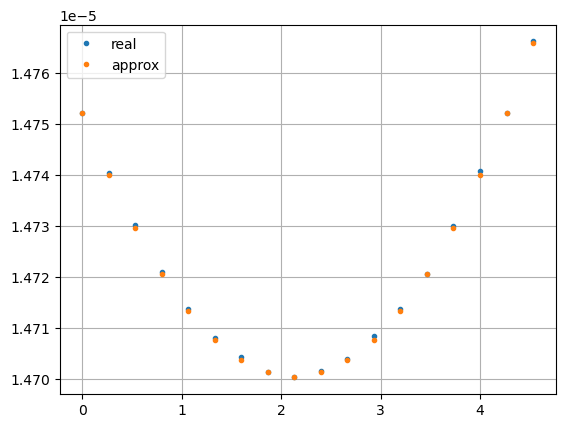

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


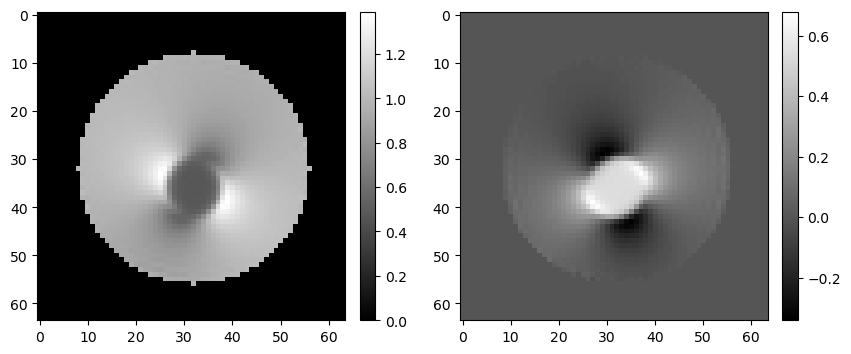

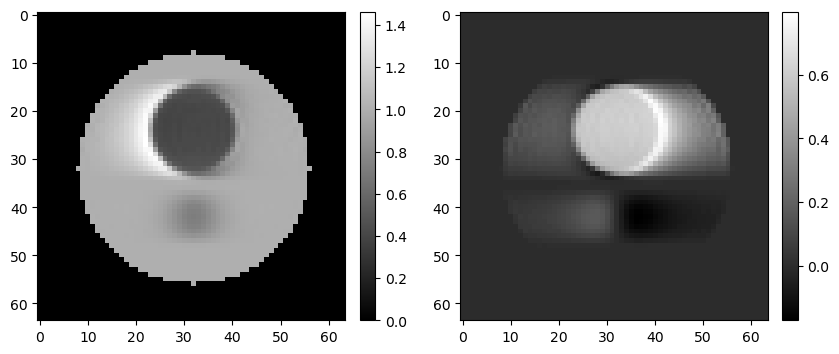

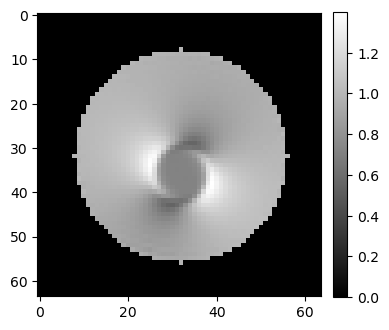

464 err=1.3846733054379001e-05
480 err=1.3006376320845447e-05
496 err=1.2102763321308885e-05
512 err=1.1270502000115812e-05
phi=array([1., 1.], dtype=float32),a=array(0.)


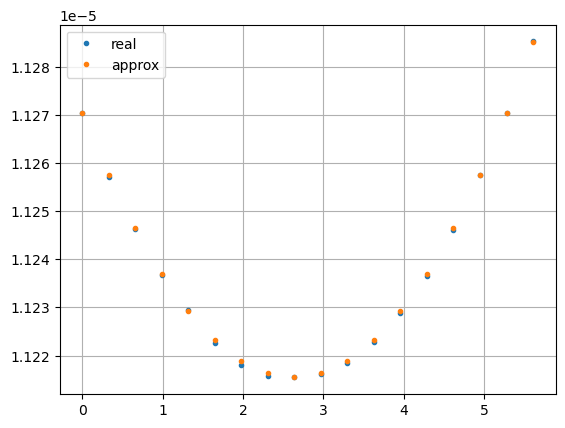

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


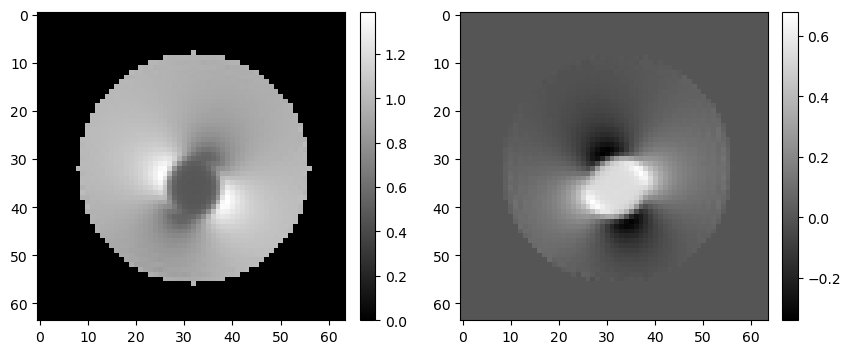

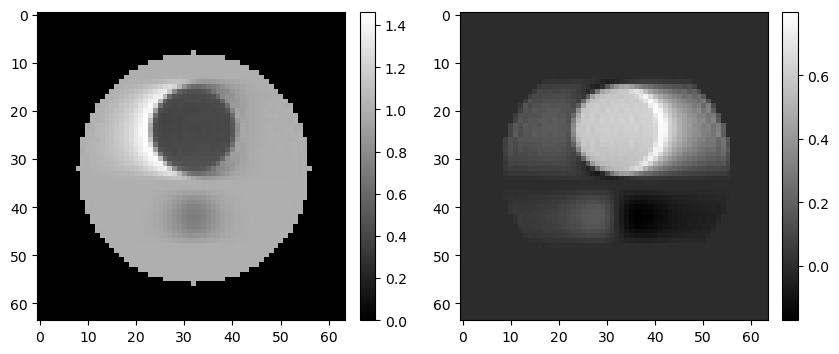

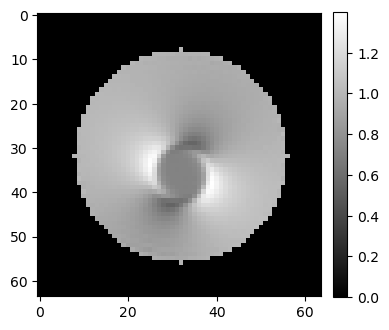

528 err=1.0546872545091901e-05
544 err=9.875810064841062e-06
560 err=9.33210139919538e-06
576 err=8.778847586654592e-06
phi=array([1., 1.], dtype=float32),a=array(0.)


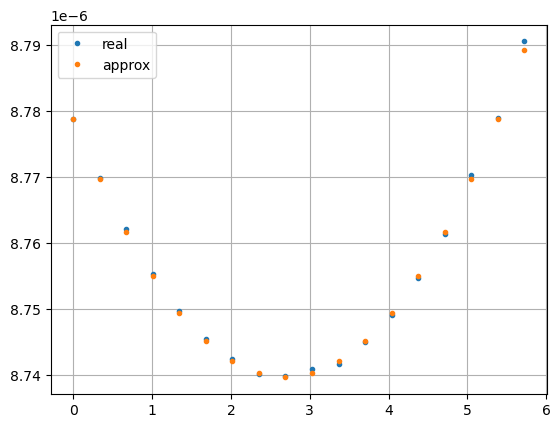

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


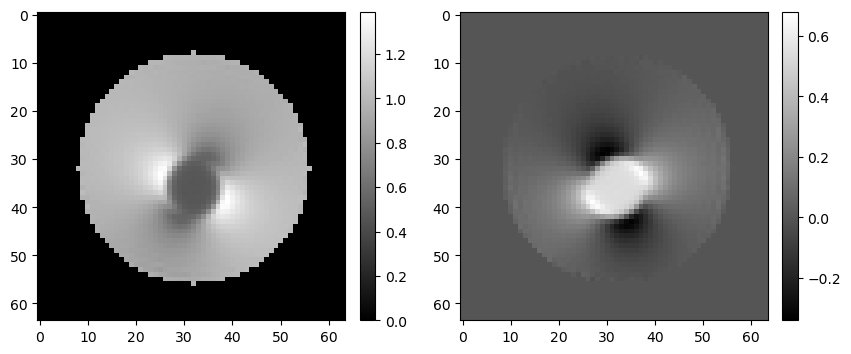

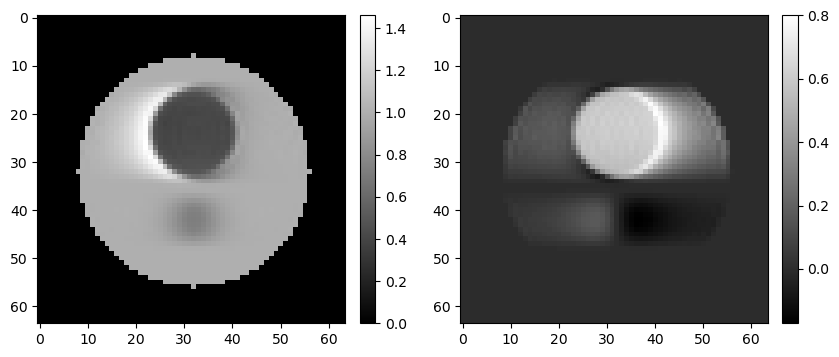

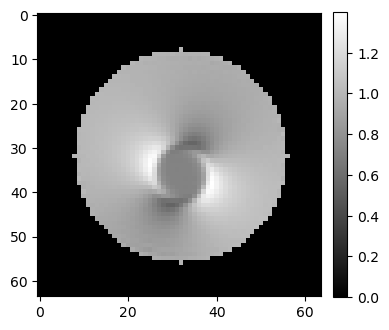

592 err=8.36179606267251e-06
608 err=7.985706361068878e-06
624 err=7.515767720178701e-06
640 err=7.077384907461237e-06
phi=array([1., 1.], dtype=float32),a=array(0.)


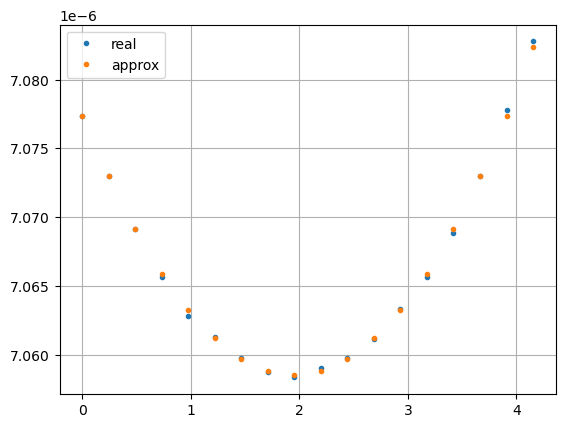

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


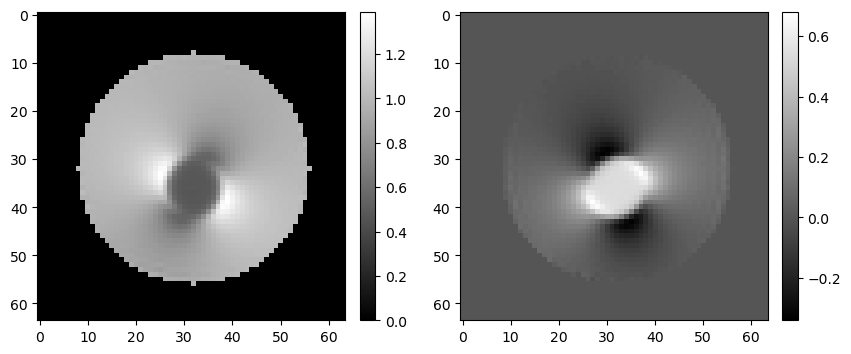

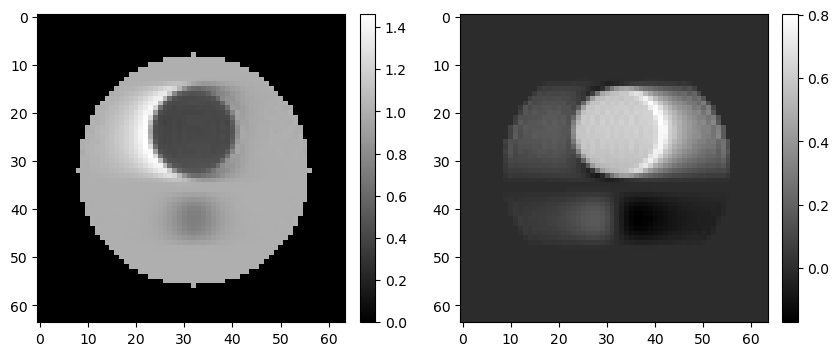

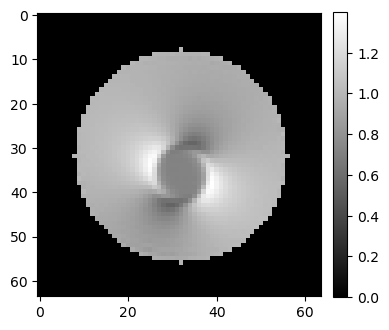

656 err=6.785905043216189e-06
672 err=6.555292657139944e-06
688 err=6.333582859952003e-06
704 err=6.166867478896165e-06
phi=array([1., 1.], dtype=float32),a=array(0.)


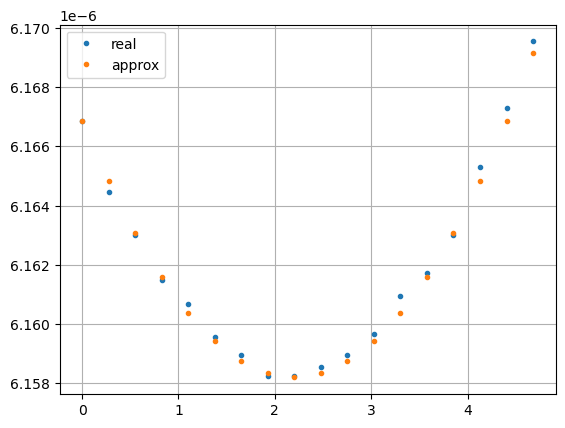

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


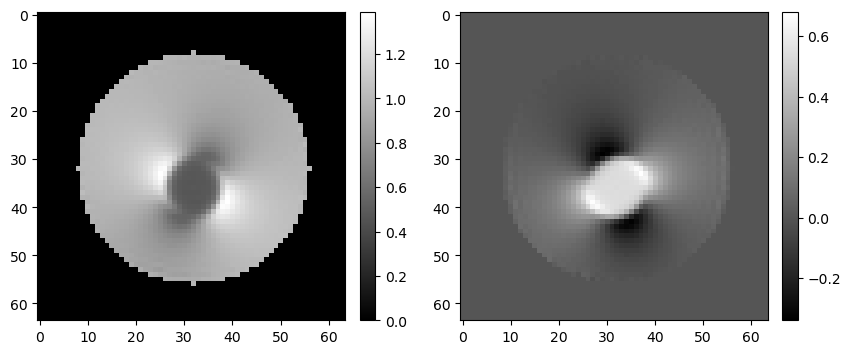

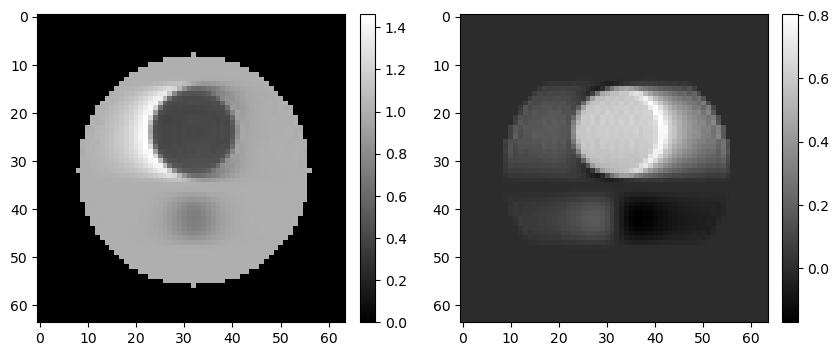

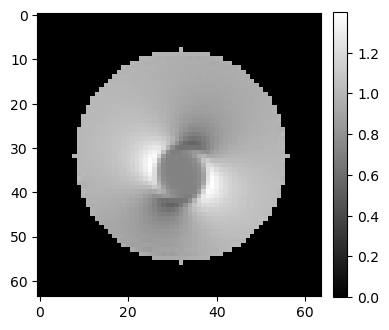

720 err=6.027067684044596e-06
736 err=5.841615347890183e-06
752 err=5.60346325073624e-06
768 err=5.405789579526754e-06
phi=array([1., 1.], dtype=float32),a=array(0.)


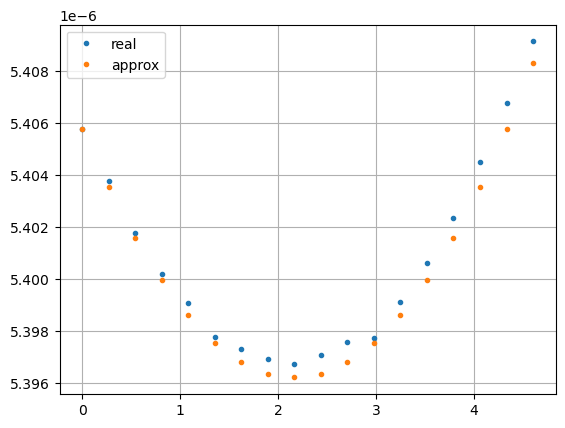

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


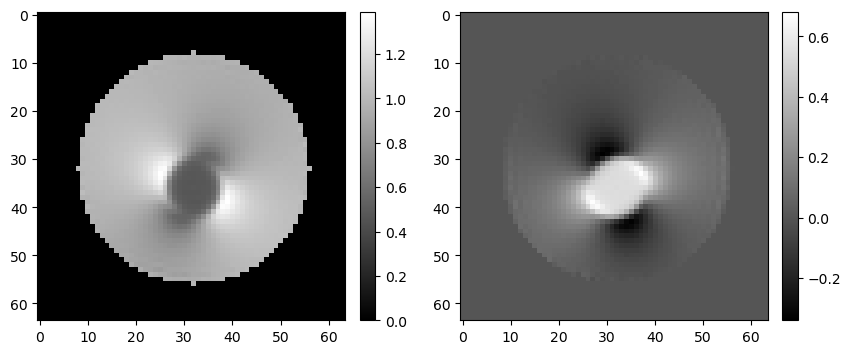

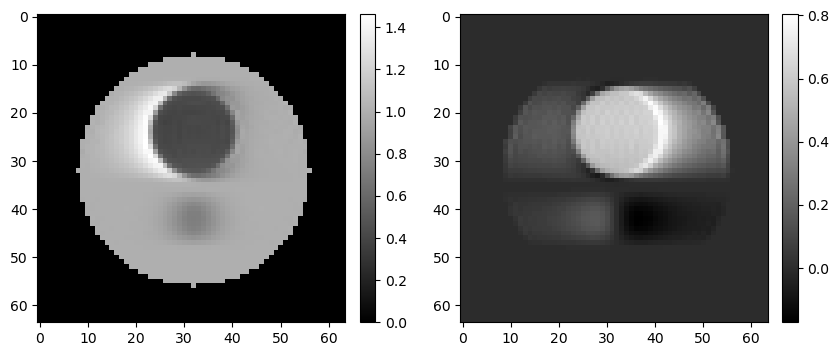

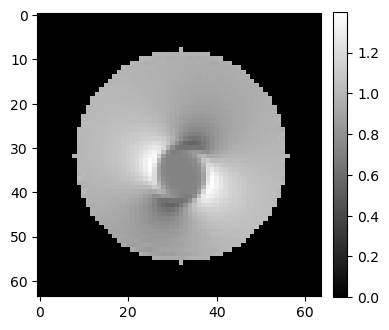

784 err=5.286643045110395e-06
800 err=5.1857718972314615e-06
816 err=5.0695857680693734e-06
832 err=4.828122655453626e-06
phi=array([1., 1.], dtype=float32),a=array(0.)


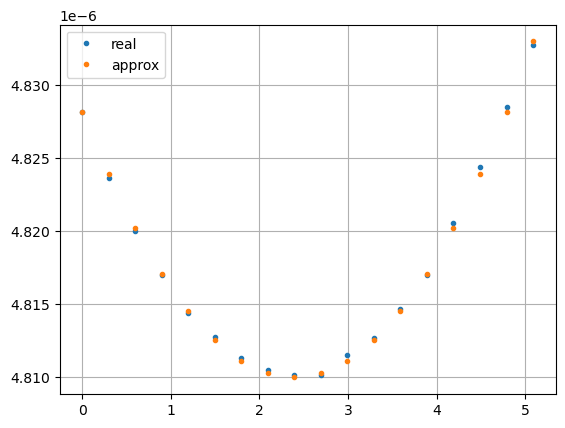

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


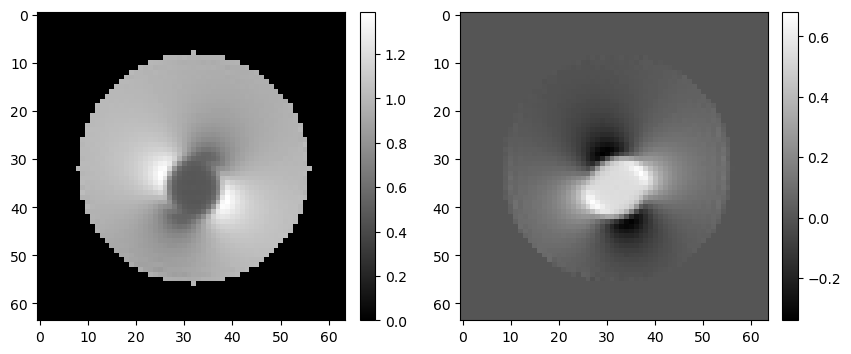

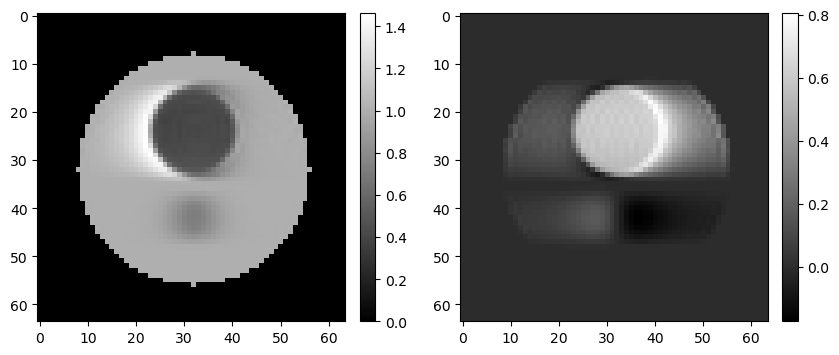

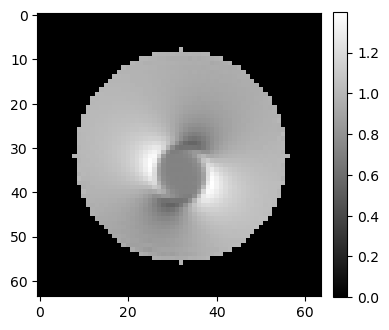

848 err=4.695525603892747e-06
864 err=4.586169325193623e-06
880 err=4.464355697564315e-06
896 err=4.369140697235707e-06
phi=array([1., 1.], dtype=float32),a=array(0.)


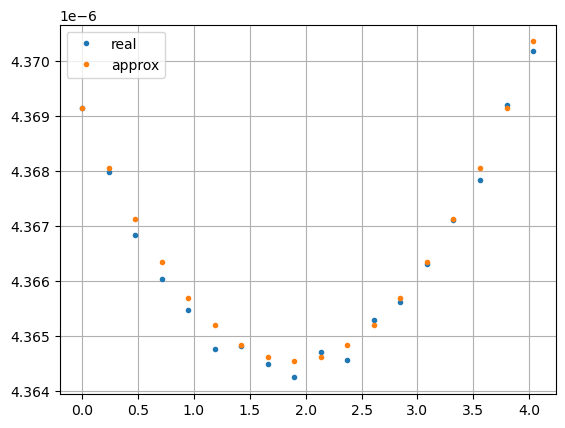

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


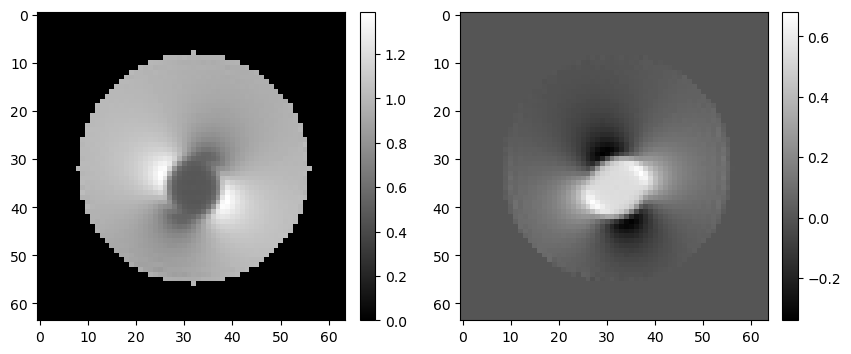

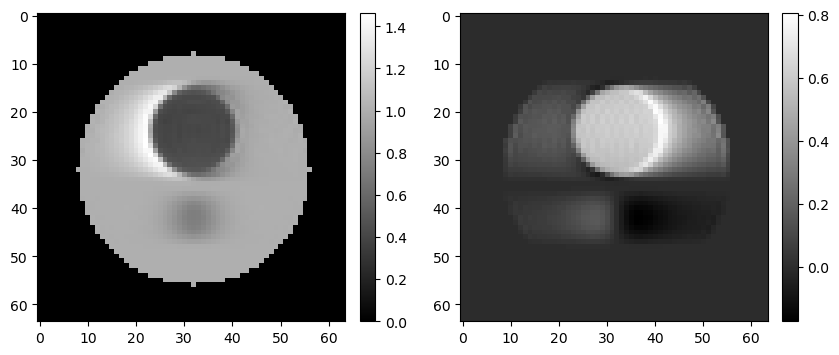

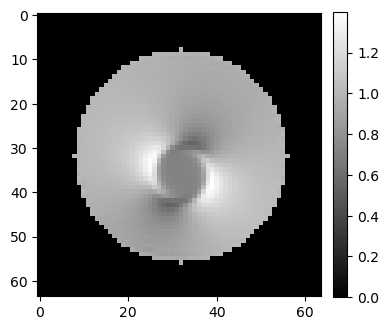

912 err=4.272075784683693e-06
928 err=4.179615189059405e-06
944 err=4.099591023987159e-06
960 err=4.018971594632603e-06
phi=array([1., 1.], dtype=float32),a=array(0.)


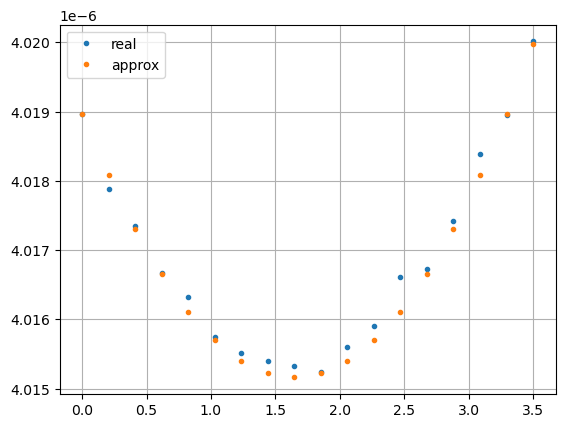

vars['phi']=array([1., 1.], dtype=float32)
vars['a']=array(0.)


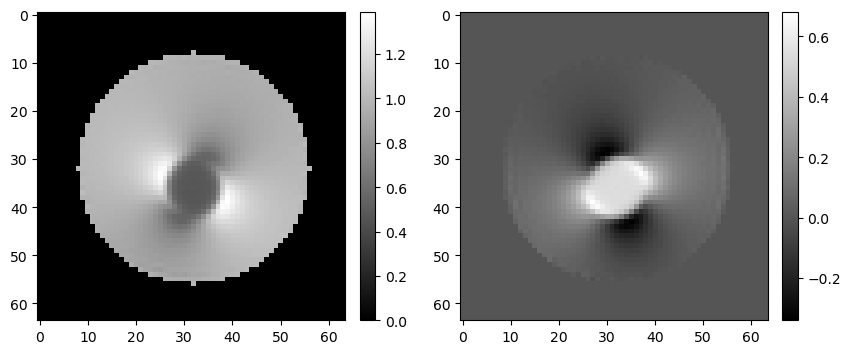

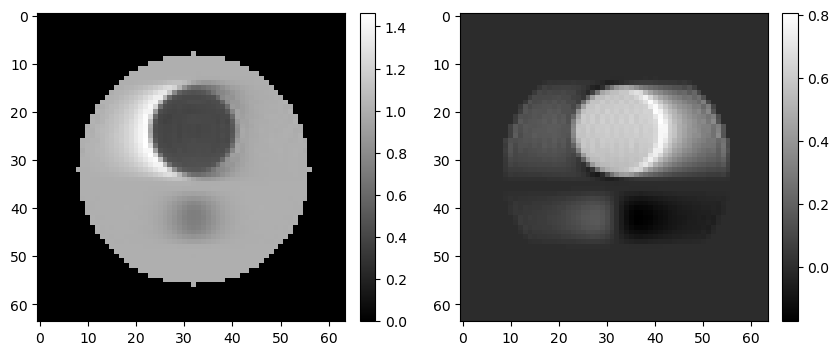

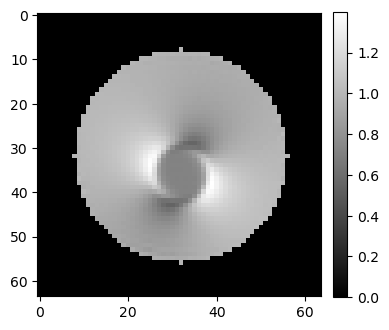

976 err=3.947416644223267e-06
992 err=3.837244094029302e-06
1008 err=3.7073327803227585e-06


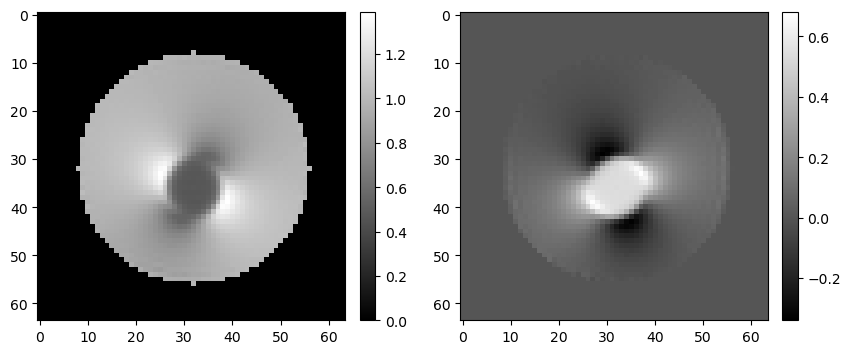

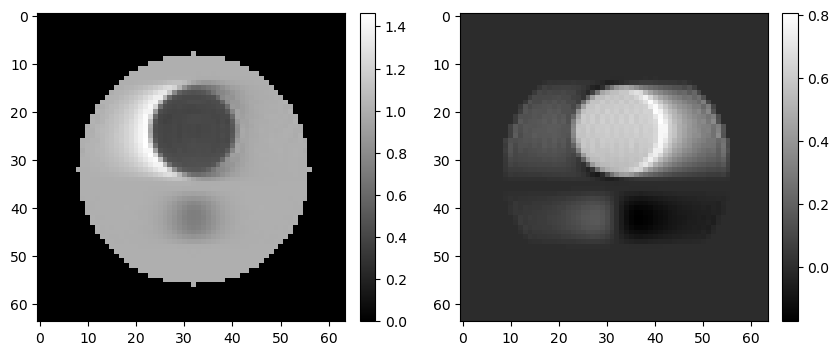

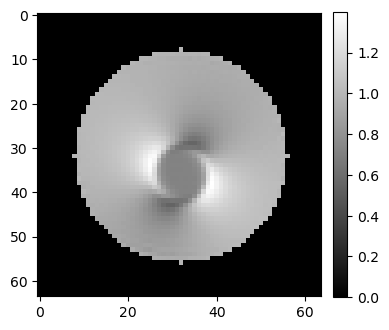

In [25]:
# initial guess
vars = {}
vars['w'] = w*0
vars['phi'] = cp.array([1,1],dtype='float32')
vars['a'] = cp.float32(0)
lam = [0.0000,0.0]
niter = 1024
vars,err2 = BH(vars,data,niter,lam)

mshow_complex(vars['w'][w_shape[0]//2,:,:,0]+1j*vars['w'][w_shape[0]//2,:,:,1])
mshow_complex(vars['w'][:,w_shape[1]//2,:,0]+1j*vars['w'][:,w_shape[1]//2,:,1])
mshow(np.linalg.norm(vars['w'][w.shape[0]//2],axis=-1),True)

In [26]:
# vars['phi']